In [1]:
import numpy as np
from grakel.datasets import fetch_dataset
from grakel.kernels import WeisfeilerLehman, VertexHistogram
from grakel.kernels import SubgraphMatching, GraphletSampling, ShortestPath, RandomWalk
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

def check_tria_ineq(K_candidate):
    D = 0.5* (np.diag(K_candidate).reshape(-1,1) @ np.ones((K_candidate.shape[0], 1)).T + np.ones((K_candidate.shape[0], 1)) @ np.diag(K_candidate).reshape(1,-1)) - K_candidate
    # sns.heatmap(D)
    # plt.title(f'Distance')
    # plt.show()
    tria_ineq = True
    for x in range(len(D)):
        if not tria_ineq: break
        for y in range(x+1, len(D)):
            if not tria_ineq: break
            for z in range(y+1, len(D)):
                if not tria_ineq: break
                diff1 = D[x,y] + D[x,z] - D[y,z]
                diff2 = D[x,z] + D[y,z] - D[x,y]
                diff3 = D[y,z] + D[x,y] - D[x,z]
                if (diff1 < 0 ) or (diff2 < 0 ) or (diff3 < 0):
                    print(f'Invalid Triangle Inequality (Triplet: No.{x+1,y+1,z+1})')
                    print(f'D[{x},{y}] + D[{x},{z}] - D[{y},{z}] {diff1}')
                    print(f'D[{x},{z}] + D[{y},{z}] - D[{x},{y}] {diff2}')
                    print(f'D[{y},{z}] + D[{x},{y}] - D[{x},{z}] {diff3}')
                    tria_ineq = False

    return tria_ineq

def check_psd(K):
    eigenValues = np.linalg.eigvals(K) #scipy.linalg.eigh(K_new, eigvals_only=True) 
    psd = 'True'
    print("K's min eigenvalue:",min(eigenValues))
    if (0 - min(eigenValues)) > 1e-08: 
        psd = f'False\nmin eig:\n{min(eigenValues)}\nneg eig num:{len(np.argwhere(eigenValues<0))}'
        plt.figure(figsize=(3,2))
        sns.heatmap(K)
        plt.title(f'psd: {psd}')
        plt.show()
        psd = 'True'
        K = K - float(min(eigenValues)) * np.eye(K.shape[0])
        eigenValues = np.linalg.eigvals(K) 
        print("K_new's min eigenvalue:",min(eigenValues))
        if (0 - min(eigenValues)) > 1e-08: 
            psd = f'False\nmin eig:\n{min(eigenValues)}\nneg eig num:{len(np.argwhere(eigenValues<0))}'    
    plt.figure(figsize=(3,2))
    sns.heatmap(K)
    plt.title(f'psd: {psd}')
    plt.show()

In [3]:
dataname = 'MUTAG'

print(f'Fetching {dataname} dataset...')
data = fetch_dataset(dataname.upper(), verbose=False, prefer_attr_nodes=False)
print(f'Finish fetching!')
G, y = data.data, data.target

Fetching MUTAG dataset...
Finish fetching!


In [4]:
from sklearn.model_selection import train_test_split
G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=0.2, random_state=42)

In [5]:
np.unique(y_train)

array([-1,  1])

In [6]:
G_train_adj = np.row_stack([np.array(G_train)[np.where(y_train == num)[0].astype(np.uint64)] for num in np.unique(y_train)])

G_test_adj = np.row_stack([np.array(G_test)[np.where(y_test == num)[0].astype(np.uint64)] for num in np.unique(y_test)])

In [7]:
y_train_adj = np.concatenate([y_train[np.argwhere(y_train == num).ravel()] for num in np.unique(y_train)])
y_test_adj = np.concatenate([y_test[np.argwhere(y_test == num).ravel()]  for num in np.unique(y_train)])

In [8]:
[len(np.where(y_train == num)[0]) for num in np.unique(y_train)], len(G_train_adj), [len(np.where(y_test == num)[0]) for num in np.unique(y_test)], len(G_test_adj)

([51, 99], 150, [12, 26], 38)

In [9]:
def get_WL(G, G_test, iter_num = 1):
    wl_kernel = WeisfeilerLehman(n_iter=iter_num, normalize=True, base_graph_kernel=VertexHistogram)
    K = wl_kernel.fit_transform(G)
    K_test = wl_kernel.transform(G_test)
    # plt.figure(figsize=(14,12))
    # sns.heatmap(K)
    plt.figure(1, (10, 4))

    plt.subplot(1, 2, 1)
    sns.heatmap(K)
    plt.title(f'WL-{iter_num} train')

    plt.subplot(1, 2, 2)
    sns.heatmap(K_test)
    plt.title(f'WL-{iter_num} test')
    plt.show()

    return K, K_test

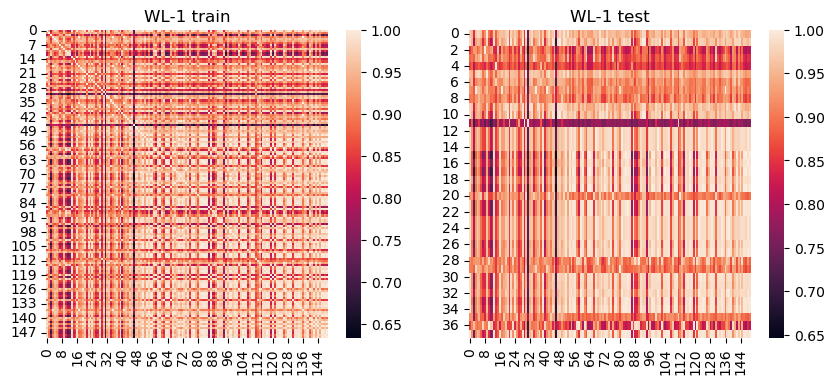

In [10]:
K_WL_1, K_WL_1_test = get_WL(G_train_adj, G_test_adj, 1)

[46 31  2 11 29]


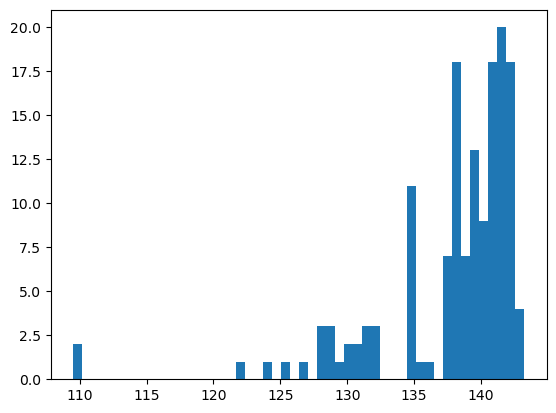

In [11]:
row_sum = np.sum(K_WL_1, axis = 1)
print(np.argsort(row_sum)[:5])
plt.hist(row_sum, bins = 50)
plt.show()

Num of negative value: 0
Is symmetry: True
Invalid Triangle Inequality (Triplet: No.(1, 2, 3))
D[0,1] + D[0,2] - D[1,2] 0.14140004483341317
D[0,2] + D[1,2] - D[0,1] 0.31403161572874794
D[1,2] + D[0,1] - D[0,2] -0.00507170215552688
Is triangle inequality: False
K's min eigenvalue: (-5.611890748382715e-15+0j)


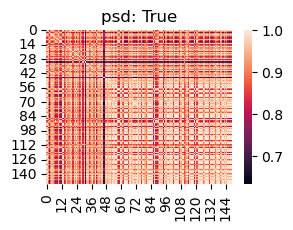

In [12]:
print("Num of negative value:",np.sum(K_WL_1 < 0))
print("Is symmetry:",check_symmetric(K_WL_1))
print("Is triangle inequality:", check_tria_ineq(K_WL_1))
check_psd(K_WL_1)

K's min eigenvalue: (-5.611890748382715e-15+0j)


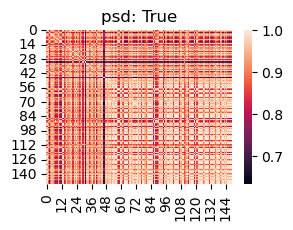

In [899]:
check_psd(K_WL_1)

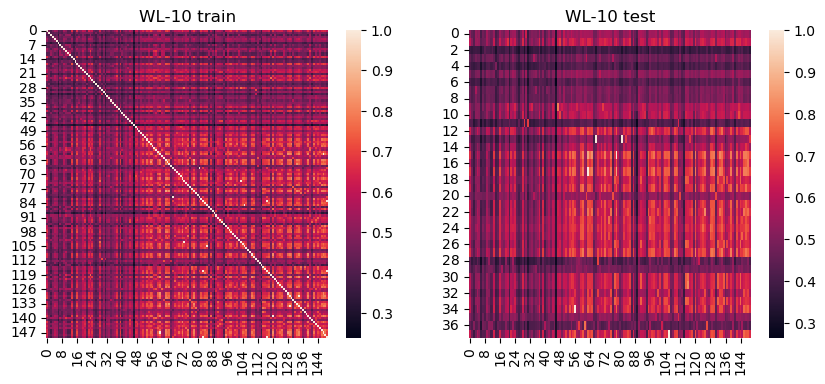

In [696]:
K_WL_10, K_WL_10_test = get_WL(G_train_adj, G_test_adj, 10)

In [697]:
row_sum = np.sum(K_WL_10, axis = 1)
print(np.argsort(row_sum)[:5])
plt.hist(row_sum, bins = 50)
plt.show()

[46 89  6 31 14]


Num of negative value: 0
Is symmetry: True
Is triangle inequality: True
K's min eigenvalue: (-9.720003376568809e-17+0j)


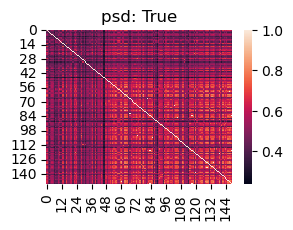

In [698]:
print("Num of negative value:",np.sum(K_WL_10 < 0))
print("Is symmetry:",check_symmetric(K_WL_10))
print("Is triangle inequality:", check_tria_ineq(K_WL_10))
check_psd(K_WL_10)

In [699]:
def get_GS(G, G_test, k_num = 4):
    wl_kernel = GraphletSampling(normalize=True, k=k_num)
    K = wl_kernel.fit_transform(G)
    K_test = wl_kernel.transform(G_test)
    print('Done fitting')
    print('Start plotting')

    plt.figure(1, (10, 4))

    plt.subplot(1, 2, 1)
    sns.heatmap(K)
    plt.title(f'GS-{k_num} train')

    plt.subplot(1, 2, 2)
    sns.heatmap(K_test)
    plt.title(f'GS-{k_num} test')
    plt.show()
    
    return K, K_test

Done fitting
Start plotting


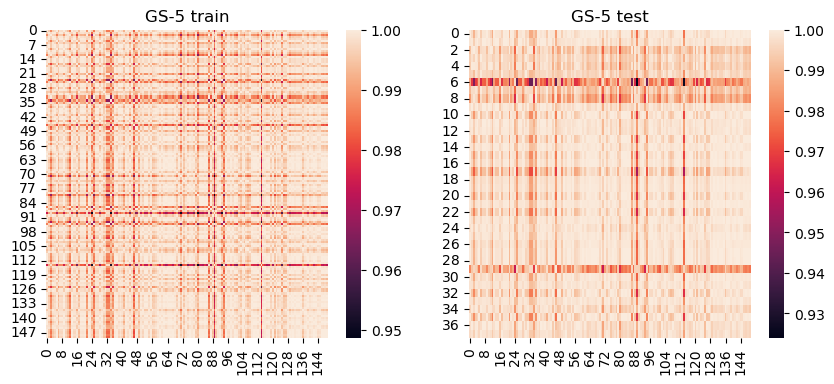

In [700]:
K_GS_5, K_GS_5_test = get_GS(G_train_adj, G_test_adj, 5)

[ 89 114  46  33  32]


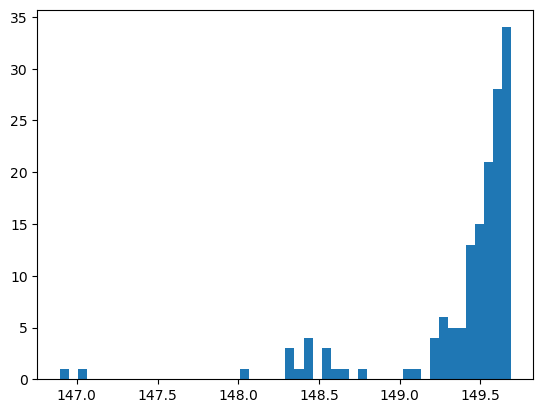

In [701]:
row_sum = np.sum(K_GS_5, axis = 1)
print(np.argsort(row_sum)[:5])
plt.hist(row_sum, bins = 50)
plt.show()

Num of negative value: 0
Is symmetry: True
Invalid Triangle Inequality (Triplet: No.(1, 2, 3))
D[0,1] + D[0,2] - D[1,2] 0.013661365318608731
D[0,2] + D[1,2] - D[0,1] 0.010812704023253183
D[1,2] + D[0,1] - D[0,2] -0.006026489255424372
Is triangle inequality: False
K's min eigenvalue: (-1.8089885372390536e-15+0j)


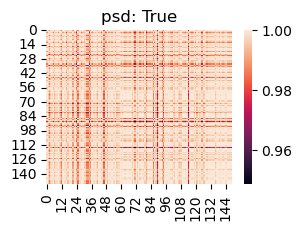

In [702]:
print("Num of negative value:",np.sum(K_GS_5 < 0))
print("Is symmetry:",check_symmetric(K_GS_5))
print("Is triangle inequality:", check_tria_ineq(K_GS_5))
check_psd(K_GS_5)

In [703]:
K_GS_8, K_GS_8_test = get_GS(G_train_adj, G_test_adj, 8)

Done fitting
Start plotting


In [704]:
row_sum = np.sum(K_GS_8, axis = 1)
print(np.argsort(row_sum)[:5])
plt.hist(row_sum, bins = 50)
plt.show()

[43 38 27  1 36]


Num of negative value: 0
Is symmetry: True
Invalid Triangle Inequality (Triplet: No.(1, 2, 6))
D[0,1] + D[0,5] - D[1,5] 0.10169127429250546
D[0,5] + D[1,5] - D[0,1] -0.039707625778072964
D[1,5] + D[0,1] - D[0,5] 0.7673406769260139
Is triangle inequality: False
K's min eigenvalue: (-1.4281770317710115e-15-8.417420953914763e-17j)


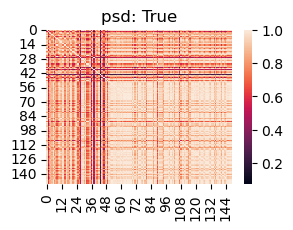

In [705]:
print("Num of negative value:",np.sum(K_GS_8 < 0))
print("Is symmetry:",check_symmetric(K_GS_8))
print("Is triangle inequality:", check_tria_ineq(K_GS_8))
check_psd(K_GS_8)

In [706]:
def get_SP(G, G_test):
    wl_kernel = ShortestPath(normalize=True, algorithm_type="floyd_warshall")
    K = wl_kernel.fit_transform(G)
    K_test = wl_kernel.transform(G_test)
    print('Done fitting')
    print('Start plotting')
    plt.figure(1, (10, 4))

    plt.subplot(1, 2, 1)
    sns.heatmap(K)
    plt.title(f'SP train')

    plt.subplot(1, 2, 2)
    sns.heatmap(K_test)
    plt.title(f'SP test')
    plt.show()
    
    return K, K_test

Done fitting
Start plotting


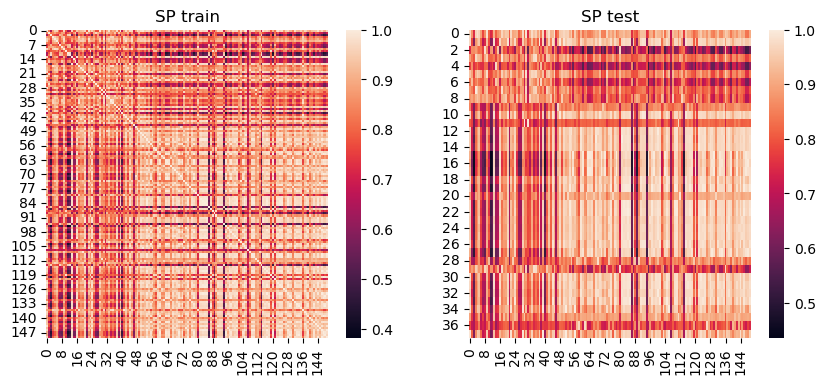

In [707]:
K_SP, K_SP_test = get_SP(G_train_adj, G_test_adj)

[11  2 40 12 86]


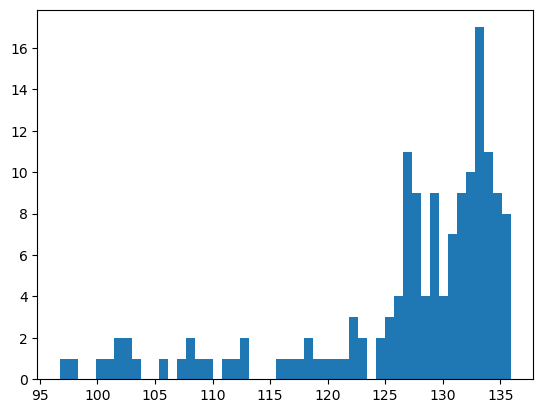

In [708]:
row_sum = np.sum(K_SP, axis = 1)
print(np.argsort(row_sum)[:5])
plt.hist(row_sum, bins = 50)
plt.show()

Num of negative value: 0
Is symmetry: True
Invalid Triangle Inequality (Triplet: No.(1, 2, 5))
D[0,1] + D[0,4] - D[1,4] 0.10081812516573097
D[0,4] + D[1,4] - D[0,1] -0.007109950882869809
D[1,4] + D[0,1] - D[0,4] 0.2240943003497351
Is triangle inequality: False
K's min eigenvalue: (-8.619957627057763e-16-6.07574468804349e-17j)


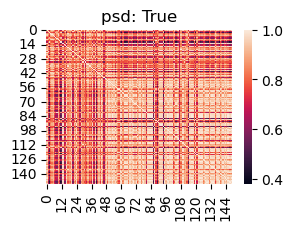

In [709]:
print("Num of negative value:",np.sum(K_SP < 0))
print("Is symmetry:",check_symmetric(K_SP))
print("Is triangle inequality:", check_tria_ineq(K_SP))
check_psd(K_SP)

In [900]:
def get_RW(G, G_test, lambda_value = 0.1):
    wl_kernel = RandomWalk(lamda=lambda_value, normalize=True, kernel_type="exponential")
    K = wl_kernel.fit_transform(G)
    K_test = wl_kernel.transform(G_test)
    print('Done fitting')
    print('Start plotting')
    plt.figure(1, (10, 4))

    plt.subplot(1, 2, 1)
    sns.heatmap(K)
    plt.title(f'RW-{lambda_value} train')

    plt.subplot(1, 2, 2)
    sns.heatmap(K_test)
    plt.title(f'RW-{lambda_value} test')
    plt.show()
    
    return K, K_test

Done fitting
Start plotting


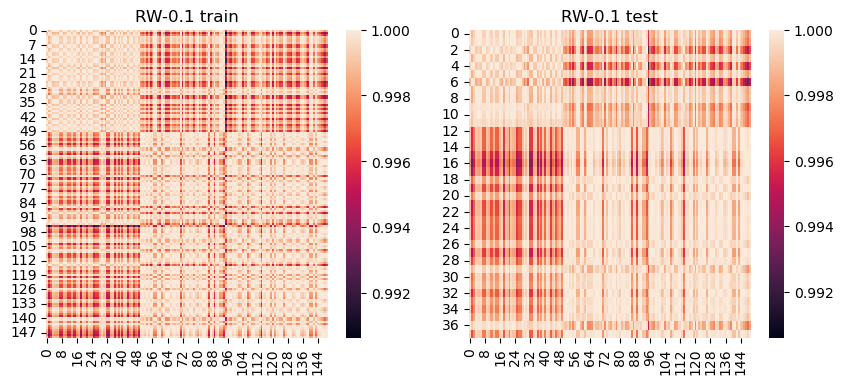

In [901]:
K_RW_01, K_RW_01_test = get_RW(G_train_adj, G_test_adj, 0.1)

[95  1 18 25 33]


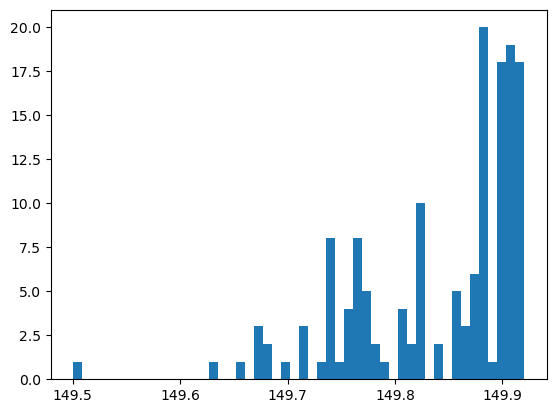

In [ ]:
row_sum = np.sum(K_RW_01, axis = 1)
print(np.argsort(row_sum)[:5])
plt.hist(row_sum, bins = 50)
plt.show()

In [ ]:
print("Num of negative value:",np.sum(K_RW_01 < 0))
print("Is symmetry:",check_symmetric(K_RW_01))
print("Is triangle inequality:", check_tria_ineq(K_RW_01))
check_psd(K_RW_01)

Num of negative value: 0
Is symmetry: True
Invalid Triangle Inequality (Triplet: No.(1, 2, 3))
D[0,1] + D[0,2] - D[1,2] 0.0015707371678612692
D[0,2] + D[1,2] - D[0,1] -0.00043715736640548286
D[1,2] + D[0,1] - D[0,2] 0.0008991734551064834
Is triangle inequality: False
K's min eigenvalue: (-5.659048681740406e-15+0j)


In [ ]:
K_RW_05, K_RW_05_test = get_RW(G_train_adj, G_test_adj, 0.5)

Done fitting
Start plotting


[ 95  32  25  33 148]


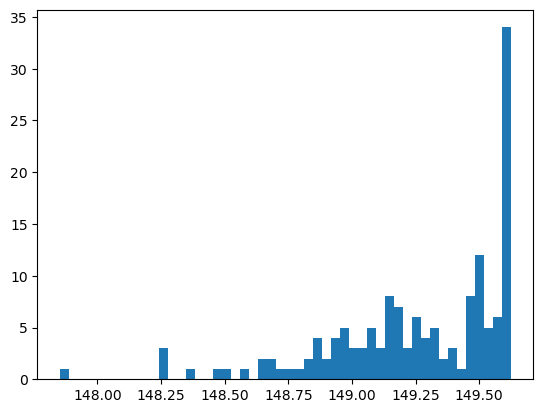

In [ ]:
row_sum = np.sum(K_RW_05, axis = 1)
print(np.argsort(row_sum)[:5])
plt.hist(row_sum, bins = 50)
plt.show()

Num of negative value: 0
Is symmetry: True
Invalid Triangle Inequality (Triplet: No.(1, 2, 3))
D[0,1] + D[0,2] - D[1,2] 0.0016417538413499022
D[0,2] + D[1,2] - D[0,1] -0.0011287334511426161
D[1,2] + D[0,1] - D[0,2] 0.0060928329645629775
Is triangle inequality: False
K's min eigenvalue: (-7.10995953838245e-15+0j)


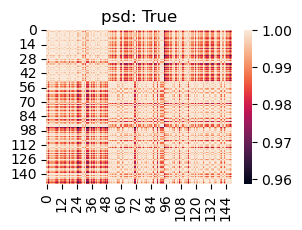

In [902]:
print("Num of negative value:",np.sum(K_RW_05 < 0))
print("Is symmetry:",check_symmetric(K_RW_05))
print("Is triangle inequality:", check_tria_ineq(K_RW_05))
check_psd(K_RW_05)

In [ ]:
import scipy
from scipy.sparse import csgraph
from sklearn.cluster import SpectralClustering
from sklearn import metrics
import pandas as pd

In [ ]:
def cal_acc(y_true, y_pred):
    """
    Calculate clustering accuracy.
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from scipy.optimize import linear_sum_assignment as linear_assignment
    ind_row, ind_col = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in zip(ind_row, ind_col)]) * 1.0 / y_pred.size


def cal_Lap_eigen(K, class_num):
    L = csgraph.laplacian(K, normed=True)
    eigenValues, eigenVectors = scipy.linalg.eigh(L, subset_by_index=[class_num-1, class_num])
    assert len(eigenValues) == class_num
    return (eigenValues, eigenVectors[0], eigenVectors[1])

def gk_L(K, coef = 1):

    n = K.shape[0]
    D = np.sum(K, axis = 0)

    D15 = np.diag(np.power(D, -1.5))
    D05 = np.diag(np.power(D, -0.5))
    D1 = np.diag(np.power(D, -1))

    U0 = - 0.5 * D15 @ K @ D05 * coef
    U1 = - 0.5 * D05 @ K @ D15 * coef

    U0 = np.tile(U0.sum(axis = 1), (n, 1))
    U1 = np.transpose(np.tile(U1.sum(axis = 0), (n, 1)))
    grad_K = - (U0 + U1 + D1 * coef)
    
    return grad_K

def gw_K(K_list):
    return np.array(K_list)

def get_Knew(prev_w, K_list):
    T = len(prev_w)
    p, q = K_list[0].shape

    K_new = np.zeros((p, q))
    for t in range(T):
        K_new += prev_w[t] * K_list[t]
    return K_new

def cal_grad_w(prev_w, K_list, K_new, class_num):

    T = len(prev_w)
    eigenValues, eigenV_kp1, eigenV = cal_Lap_eigen(K_new, class_num)
    eigen_k = eigenValues[0]
    eigen_gap = np.diff(eigenValues)
    eigen_gap_ratio = eigen_gap/eigen_k
    eigenV_kp1_trace = np.transpose(eigenV_kp1 @ eigenV_kp1)
    eigenV_trace = np.transpose(eigenV @ eigenV)
    inv_trace1 = np.power(eigen_gap, -1) * (eigenV_kp1_trace - eigenV_trace)
    inv_trace2 = np.power(eigen_k,-1) * (eigenV_trace)

    grad_LK = gk_L(K_new, (inv_trace1 - inv_trace2))
    grad_Lw = gw_K(K_list)
    grad = np.sum(np.sum(grad_Lw * grad_LK, axis = 1), axis = 1)

    return grad.flatten(), eigen_gap_ratio


In [729]:
def update_adam(weights, grad, t, m, v, alpha, beta1, beta2, eps=1e-8):
    m = beta1 * m + (1.0 - beta1) * grad
    v = beta2 * v + (1.0 - beta2) * grad**2
    mhat = m / (1.0 - beta1**(t+1))
    vhat = v / (1.0 - beta2**(t+1))
    weights = weights + alpha * mhat / (np.sqrt(vhat) + eps)
    return (weights, m, v)

def proj_update(weights, simplex = 1):
    n = len(weights)
    return np.maximum(weights + (simplex-np.sum(weights))/n, 0)

def non_negative(weights):
    return np.abs(weights)

def scale_zero2one(weights):
    min_weight = min(weights) 
    max_weight = max(weights)
    return (weights - min_weight)/(max_weight - min_weight)

def gradient_projection(weight_num):
    A_matrix = np.row_stack([np.ones((1,weight_num)), np.eye(weight_num)[:weight_num-1,:]])
    assert(A_matrix.shape[0] == A_matrix.shape[1])
    AA_inv = np.linalg.inv(A_matrix @ A_matrix.T)
    P = np.eye(len(A_matrix)) - A_matrix.T @ AA_inv @ A_matrix
    return P
    

In [911]:
def project_simplex(x):
    """ Take a vector x (with possible nonnegative entries and non-normalized)
        and project it onto the unit simplex.
    """
    xsorted = np.sort(x)[::-1]
    # remaining entries need to sum up to 1
    sum_ = 1.0

    lambda_a = (np.cumsum(xsorted) - sum_) / np.arange(1.0, len(xsorted)+1.0)
    for i in range(len(lambda_a)-1):
        if lambda_a[i] >= xsorted[i+1]:
            astar = i
            break
    else:
        astar = -1

    p = np.maximum(x-lambda_a[astar],  0)
    return p

In [912]:
project_simplex(np.array([0.9,0.01,0.2]))

array([0.85, 0.  , 0.15])

In [821]:
def getMeshGrid(K_list, bins = 10):
    xlist = np.linspace(0.0, 1.0, bins)
    ylist = np.linspace(0.0, 1.0, bins)
    X, Y = np.meshgrid(xlist, ylist)
    Z = []
    acc_score_list = []
    for (xx, yy) in list(zip(X, Y)):
        for (x, y) in list(zip(xx, yy)):
            weights = np.array([x,y])
            K_new = np.nan_to_num(get_Knew(weights, K_list))
            grad, obj = cal_grad_w(weights, K_list, K_new, 2)
            Z.append(obj)

            y_pred = SpectralClustering(n_clusters = 2, 
                                    random_state = 0,
                                    affinity = 'precomputed').fit_predict(K_new)
            acc_score = cal_acc(y_train_adj, y_pred)
            acc_score_list.append(acc_score)

    Z = np.array(Z).reshape(len(xlist), len(ylist))
    acc_score_list = np.array(acc_score_list).reshape(len(xlist), len(ylist))

    Z[0][0] = None
    acc_score_list[0][0] = None
    return X, Y, Z, acc_score_list

In [837]:
K_list = [K_GS_5, K_WL_10]
n = len(K_list)
class_num = 2

score_dict = {'Accuracy': []}
weights_list = list()
gap_list = list()

stepsize = 5e-3
num_iter = 100
num_iter_mom = 250
weights = np.ones(n)/n
update_w = np.zeros(n)

for i in range(num_iter):
    if i < num_iter_mom:
        momentum = 0#.8
    else:
        momentum = 0#.3

    K_new = np.nan_to_num(get_Knew(weights, K_list))
    grad, obj = cal_grad_w(weights, K_list, K_new, class_num)
    
    '''momentum update '''
    update_w = (momentum * update_w) + (stepsize * grad)
    weights += update_w
    weights = project_simplex(weights)

    weights_list.append(weights)
    gap_list.append(obj)

    if i%10 == 0: 
        weight_norm = np.linalg.norm(weights)
        weight_sum = np.sum(weights)
        print(f'----- At No.{i+1} iteration: weights {weights} sum: {np.round(weight_sum, 4)} norm: {np.round(weight_norm, 4)}-----')
        print("grad:", grad, 'eigengap ratio:', obj)

    y_pred = SpectralClustering(n_clusters = class_num, 
                                random_state = 0,
                                affinity = 'precomputed').fit_predict(K_new)

    acc_score = cal_acc(y_train_adj, y_pred)
    # nmi = metrics.normalized_mutual_info_score(y_train_adj, y_pred)
    if i%10 == 0: print("acc_score:", acc_score)
    score_dict['Accuracy'].append(acc_score)
    # score_dict['Normalized_Mutual_Info'].append(nmi)

plt.plot(range(num_iter), gap_list)
plt.title(f'Eigengap Ratio')
plt.xlabel = 'Num of Iterations'
plt.show()

----- At No.1 iteration: weights [0.49724152 0.50275848] sum: 1.0 norm: 0.7071-----
grad: [-2.36257799 -1.25918771] eigengap ratio: [0.02210241]
acc_score: 0.5266666666666666
----- At No.11 iteration: weights [0.47204296 0.52795704] sum: 1.0 norm: 0.7082-----
grad: [-2.00506567 -1.06844643] eigengap ratio: [0.02348627]
acc_score: 0.5266666666666666
----- At No.21 iteration: weights [0.45047267 0.54952733] sum: 1.0 norm: 0.7106-----
grad: [-1.72716277 -0.92020886] eigengap ratio: [0.02470347]
acc_score: 0.54
----- At No.31 iteration: weights [0.43177495 0.56822505] sum: 1.0 norm: 0.7137-----
grad: [-1.50400998 -0.80119906] eigengap ratio: [0.02578401]
acc_score: 0.54
----- At No.41 iteration: weights [0.41541527 0.58458473] sum: 1.0 norm: 0.7172-----
grad: [-1.32049188 -0.70334507] eigengap ratio: [0.02674957]
acc_score: 0.54
----- At No.51 iteration: weights [0.40099826 0.59900174] sum: 1.0 norm: 0.7208-----
grad: [-1.16680765 -0.6214133 ] eigengap ratio: [0.02761659]
acc_score: 0.54
-

In [824]:
K_list = [K_GS_5, K_WL_10]
X, Y, Z, acc_score_list = getMeshGrid(K_list)
plt.figure(1, (10, 4))
plt.subplot(1, 2, 1)
plt.contourf(X, Y, Z)
plt.colorbar()
plt.title('Eigengap Ratio')
plt.subplot(1, 2, 2)
plt.contourf(X, Y, acc_score_list)
plt.colorbar()
plt.title('Acc score')
plt.show()

In [834]:
K_list = [K_GS_5, K_RW_01]
n = len(K_list)
class_num = 2

score_dict = {'Accuracy': []}
weights_list = list()
gap_list = list()

stepsize = 5e-3
num_iter = 200
num_iter_mom = 250
weights = np.array([0.2,0.8])##np.ones(n)/n
update_w = np.zeros(n)

for i in range(num_iter):
    if i < num_iter_mom:
        momentum = 0#.8
    else:
        momentum = 0#.3

    K_new = np.nan_to_num(get_Knew(weights, K_list))
    grad, obj = cal_grad_w(weights, K_list, K_new, class_num)
    
    '''momentum update '''
    update_w = (momentum * update_w) + (stepsize * grad)
    weights += update_w
    weights = project_simplex(weights)

    weights_list.append(weights)
    gap_list.append(obj)

    if i%10 == 0: 
        weight_norm = np.linalg.norm(weights)
        weight_sum = np.sum(weights)
        print(f'----- At No.{i+1} iteration: weights {weights} sum: {np.round(weight_sum, 4)} norm: {np.round(weight_norm, 4)}-----')
        print("grad:", grad, 'eigengap ratio:', obj)

    y_pred = SpectralClustering(n_clusters = class_num, 
                                random_state = 0,
                                affinity = 'precomputed').fit_predict(K_new)

    acc_score = cal_acc(y_train_adj, y_pred)
    # nmi = metrics.normalized_mutual_info_score(y_train_adj, y_pred)
    if i%10 == 0: print("acc_score:", acc_score)
    score_dict['Accuracy'].append(acc_score)
    # score_dict['Normalized_Mutual_Info'].append(nmi)

plt.plot(range(num_iter), gap_list)
plt.title(f'Eigengap Ratio')
plt.xlabel = 'Num of Iterations'
plt.show()

----- At No.1 iteration: weights [0.22510707 0.77489293] sum: 1.0 norm: 0.8069-----
grad: [-3286.26739004 -3296.31021676] eigengap ratio: [0.00079941]
acc_score: 0.6
----- At No.11 iteration: weights [0.42512498 0.57487502] sum: 1.0 norm: 0.715-----
grad: [-2113.90681664 -2120.36881858] eigengap ratio: [0.00127005]
acc_score: 0.6133333333333333
----- At No.21 iteration: weights [0.55768292 0.44231708] sum: 1.0 norm: 0.7118-----
grad: [-1457.24398928 -1461.69950684] eigengap ratio: [0.00172524]
acc_score: 0.62
----- At No.31 iteration: weights [0.64554613 0.35445387] sum: 1.0 norm: 0.7365-----
grad: [-934.46498584 -937.32248132] eigengap ratio: [0.00201659]
acc_score: 0.62
----- At No.41 iteration: weights [0.70489162 0.29510838] sum: 1.0 norm: 0.7642-----
grad: [-677.28933659 -679.36059654] eigengap ratio: [0.00219751]
acc_score: 0.62
----- At No.51 iteration: weights [0.7508439 0.2491561] sum: 1.0 norm: 0.7911-----
grad: [-549.82460723 -551.50617177] eigengap ratio: [0.00233238]
acc_s

In [827]:
K_list = [K_GS_5, K_RW_01]
X, Y, Z, acc_score_list = getMeshGrid(K_list)
plt.figure(1, (10, 4))
plt.subplot(1, 2, 1)
plt.contourf(X, Y, Z)
plt.colorbar()
plt.title('Eigengap Ratio')
plt.subplot(1, 2, 2)
plt.contourf(X, Y, acc_score_list)
plt.colorbar()
plt.title('Acc score')
plt.show()

In [832]:
K_list = [K_WL_10, K_RW_01]
n = len(K_list)
class_num = 2

score_dict = {'Accuracy': []}
weights_list = list()
gap_list = list()

stepsize = 5e-3
num_iter = 500
num_iter_mom = 250
weights = np.array([0.3,0.7])#np.ones(n)/n
update_w = np.zeros(n)

for i in range(num_iter):
    if i < num_iter_mom:
        momentum = 0#.8
    else:
        momentum = 0#.3

    K_new = np.nan_to_num(get_Knew(weights, K_list))
    grad, obj = cal_grad_w(weights, K_list, K_new, class_num)
    
    '''momentum update '''
    update_w = (momentum * update_w) + (stepsize * grad)
    weights += update_w
    weights = project_simplex(weights)

    weights_list.append(weights)
    gap_list.append(obj)

    if i%10 == 0: 
        weight_norm = np.linalg.norm(weights)
        weight_sum = np.sum(weights)
        print(f'----- At No.{i+1} iteration: weights {weights} sum: {np.round(weight_sum, 4)} norm: {np.round(weight_norm, 4)}-----')
        print("grad:", grad, 'eigengap ratio:', obj)

    y_pred = SpectralClustering(n_clusters = class_num, 
                                random_state = 0,
                                affinity = 'precomputed').fit_predict(K_new)

    acc_score = cal_acc(y_train_adj, y_pred)
    # nmi = metrics.normalized_mutual_info_score(y_train_adj, y_pred)
    if i%10 == 0: print("acc_score:", acc_score)
    score_dict['Accuracy'].append(acc_score)
    # score_dict['Normalized_Mutual_Info'].append(nmi)

plt.plot(range(num_iter), gap_list)
plt.title(f'Eigengap Ratio')
plt.xlabel = 'Num of Iterations'
plt.show()

----- At No.1 iteration: weights [0.32585889 0.67414111] sum: 1.0 norm: 0.7488-----
grad: [-11.75958754 -22.10314396] eigengap ratio: [0.01181037]
acc_score: 0.5333333333333333
----- At No.11 iteration: weights [0.46205357 0.53794643] sum: 1.0 norm: 0.7091-----
grad: [-4.17605064 -7.85651461] eigengap ratio: [0.01900731]
acc_score: 0.54
----- At No.21 iteration: weights [0.53274142 0.46725858] sum: 1.0 norm: 0.7086-----
grad: [-2.62466668 -4.94045289] eigengap ratio: [0.02296808]
acc_score: 0.54
----- At No.31 iteration: weights [0.58096174 0.41903826] sum: 1.0 norm: 0.7163-----
grad: [-1.88997024 -3.5589032 ] eigengap ratio: [0.02583526]
acc_score: 0.54
----- At No.41 iteration: weights [0.6169956 0.3830044] sum: 1.0 norm: 0.7262-----
grad: [-1.44919559 -2.72974581] eigengap ratio: [0.02808094]
acc_score: 0.54
----- At No.51 iteration: weights [0.64521686 0.35478314] sum: 1.0 norm: 0.7363-----
grad: [-1.1520598 -2.1706035] eigengap ratio: [0.02990775]
acc_score: 0.54
----- At No.61 it

In [828]:
K_list = [K_WL_10, K_RW_01]
X, Y, Z, acc_score_list = getMeshGrid(K_list)
plt.figure(1, (10, 4))
plt.subplot(1, 2, 1)
plt.contourf(X, Y, Z)
plt.colorbar()
plt.title('Eigengap Ratio')
plt.subplot(1, 2, 2)
plt.contourf(X, Y, acc_score_list)
plt.colorbar()
plt.title('Acc score')
plt.show()

In [935]:
K_list = [K_GS_5, K_WL_10, K_RW_01]
n = len(K_list)
class_num = 2

score_dict = {'Accuracy': []}
weights_list = list()
gap_list = list()

stepsize = 1e-3
num_iter = 200
num_iter_mom = 250

# eigen_weights_list = []
# for K_train in K_list:
#     eigenValues, eigenV_kp1, eigenV = cal_Lap_eigen(K_train, class_num = 2)
#     eigen_gap = np.diff(eigenValues)
#     eigen_weights_list.append(eigen_gap)
# print(eigen_weights_list)
# eigen_weights = np.sum(np.array(eigen_weights_list)) - np.array(eigen_weights_list)
# eigen_weights /= np.sum(eigen_weights)

weights = np.ones(n)/n

for i in range(num_iter):

    K_new = np.nan_to_num(get_Knew(weights, K_list))
    grad, obj = cal_grad_w(weights, K_list, K_new, class_num)
    
    '''momentum update '''
    weights += (stepsize * grad)
    weights = project_simplex(weights)

    weights_list.append(weights)
    gap_list.append(obj)

    if i%10 == 0: 
        weight_norm = np.linalg.norm(weights)
        weight_sum = np.sum(weights)
        print(f'----- At No.{i+1} iteration: weights {weights} sum: {np.round(weight_sum, 4)} norm: {np.round(weight_norm, 4)}-----')
        print("grad:", grad, 'eigengap ratio:', obj)

    y_pred = SpectralClustering(n_clusters = class_num, 
                                random_state = 0,
                                affinity = 'precomputed').fit_predict(K_new)

    acc_score = cal_acc(y_train_adj, y_pred)
    # nmi = metrics.normalized_mutual_info_score(y_train_adj, y_pred)
    if i%10 == 0: print("acc_score:", acc_score)
    score_dict['Accuracy'].append(acc_score)
    # score_dict['Normalized_Mutual_Info'].append(nmi)

plt.plot(range(num_iter), gap_list)
plt.title(f'Eigengap Ratio')
plt.xlabel = 'Num of Iterations'
plt.show()

----- At No.1 iteration: weights [0.33160216 0.33683012 0.33156771] sum: 1.0 norm: 0.5774-----
grad: [-11.20796956  -5.98000895 -11.2424232 ] eigengap ratio: [0.01363189]
acc_score: 0.5333333333333333
----- At No.11 iteration: weights [0.31619023 0.3679608  0.31584897] sum: 1.0 norm: 0.5789-----
grad: [-9.11471575 -4.86226585 -9.14275293] eigengap ratio: [0.0150715]
acc_score: 0.5333333333333333
----- At No.21 iteration: weights [0.30335097 0.39389502 0.30275402] sum: 1.0 norm: 0.5821-----
grad: [-7.72626079 -4.12094213 -7.75004041] eigengap ratio: [0.01630447]
acc_score: 0.5333333333333333
----- At No.31 iteration: weights [0.29230027 0.41621657 0.29148316] sum: 1.0 norm: 0.5862-----
grad: [-6.72470145 -3.58624067 -6.74540885] eigengap ratio: [0.01739204]
acc_score: 0.5333333333333333
----- At No.41 iteration: weights [0.28258017 0.43585047 0.28156936] sum: 1.0 norm: 0.5908-----
grad: [-5.96121424 -3.17867582 -5.97957894] eigengap ratio: [0.01836993]
acc_score: 0.5333333333333333
----

K's min eigenvalue: (-1.8089885372390536e-15+0j)


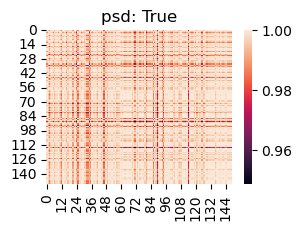

K's min eigenvalue: (-9.720003376568809e-17+0j)


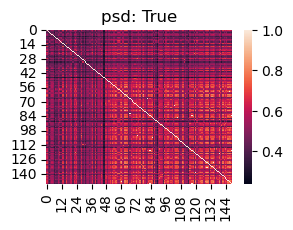

K's min eigenvalue: (-5.659048681740406e-15+0j)


K's min eigenvalue: (-5.027001348923966e-17+0j)


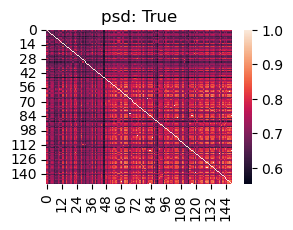

In [933]:
for (K_train) in K_list:
    check_psd(K_train)
check_psd(K_new)

===== Individual acc_score =====
Graphlet Sampling (5): 0.6066666666666667
Weisfeiler Lehman (10): 0.5333333333333333
Random Walk (0.1): 0.52
===== Joint kernel =====


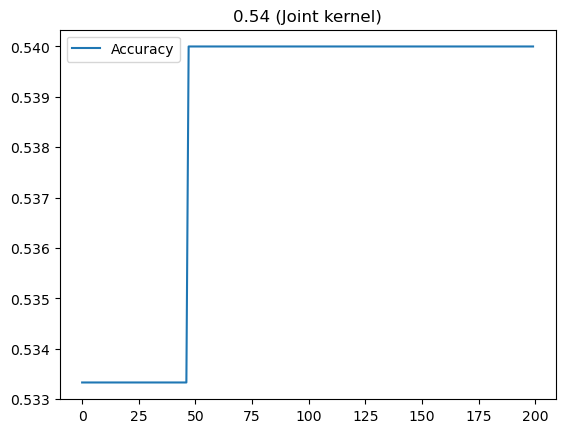

In [936]:
print('===== Individual acc_score =====')
kernel_name = ['Graphlet Sampling (5)', 'Weisfeiler Lehman (10)', 'Random Walk (0.1)']
i = 0
class_num = 2
for K_candidate in K_list:
    y_pred = SpectralClustering(n_clusters = class_num, 
                                random_state = 0,
                                affinity = 'precomputed').fit_predict(K_candidate)

    acc_score = cal_acc(y_train_adj, y_pred)
    print(f"{kernel_name[i]}:", acc_score)
    i += 1

print('===== Joint kernel =====')
plt.plot(range(num_iter), pd.DataFrame(score_dict))
plt.title(f'{max(score_dict["Accuracy"])} (Joint kernel)')
plt.legend(list(score_dict.keys()))
plt.xlabel = 'Num of Iterations'
plt.show()

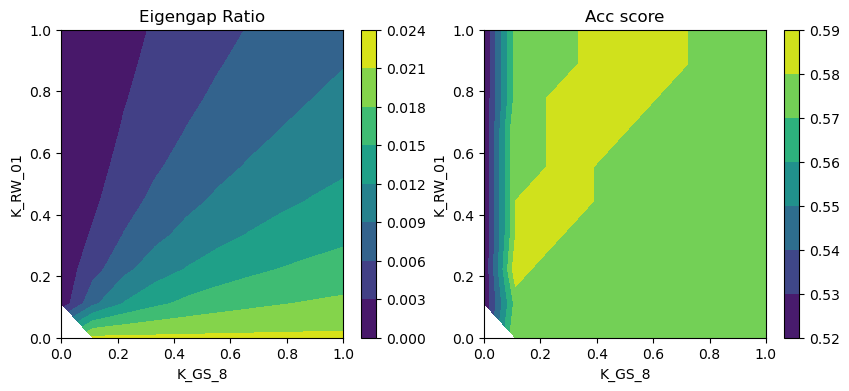

In [866]:
K_list = [K_GS_8, K_RW_01]
X, Y, Z, acc_score_list = getMeshGrid(K_list)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
cp = ax1.contourf(X, Y, Z)
f.colorbar(cp,ax=ax1) # Add a colorbar to a plot
ax1.set_xlabel('K_GS_8')
ax1.set_ylabel('K_RW_01')
ax1.set_title('Eigengap Ratio')
cp2 = ax2.contourf(X, Y, acc_score_list)
f.colorbar(cp2,ax=ax2)# Add a colorbar to a plot
ax2.set_xlabel('K_GS_8')
ax2.set_ylabel('K_RW_01')
ax2.set_title('Acc score')
plt.show()

In [929]:
a = np.random.dirichlet(np.ones(3))
sum(a)

1.0

----- At No.1 iteration: weights [0.70042091 0.29957909] sum: 1.0 norm: 0.7618-----
grad: [-1260.76469864 -1344.9458508 ] eigengap ratio: [0.00719872]
acc_score: 0.8133333333333334
----- At No.11 iteration: weights [0.70458855 0.29541145] sum: 1.0 norm: 0.764-----
grad: [-1237.59999195 -1320.28520957] eigengap ratio: [0.00737977]
acc_score: 0.8133333333333334
----- At No.21 iteration: weights [0.7086832 0.2913168] sum: 1.0 norm: 0.7662-----
grad: [-1215.44872299 -1296.70324465] eigengap ratio: [0.00756062]
acc_score: 0.8
----- At No.31 iteration: weights [0.71270808 0.28729192] sum: 1.0 norm: 0.7684-----
grad: [-1194.28777528 -1274.17547763] eigengap ratio: [0.00774098]
acc_score: 0.8
----- At No.41 iteration: weights [0.71666633 0.28333367] sum: 1.0 norm: 0.7706-----
grad: [-1174.08453546 -1252.66728874] eigengap ratio: [0.00792061]
acc_score: 0.58
----- At No.51 iteration: weights [0.72056098 0.27943902] sum: 1.0 norm: 0.7728-----
grad: [-1154.80042822 -1232.13768677] eigengap ratio:

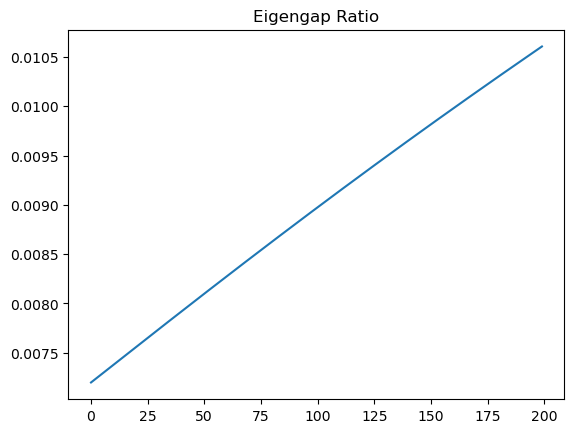

In [869]:
K_list = [K_GS_8, K_WL_1]
n = len(K_list)
class_num = 2

score_dict = {'Accuracy': []}
weights_list = list()
gap_list = list()

stepsize = 1e-5
num_iter = 200
weights = np.array([0.7,0.3])#np.ones(n)/n

for i in range(num_iter):

    K_new = np.nan_to_num(get_Knew(weights, K_list))
    grad, obj = cal_grad_w(weights, K_list, K_new, class_num)
    
    weights += (stepsize * grad)
    weights = project_simplex(weights)

    weights_list.append(weights)
    gap_list.append(obj)

    if i%10 == 0: 
        weight_norm = np.linalg.norm(weights)
        weight_sum = np.sum(weights)
        print(f'----- At No.{i+1} iteration: weights {weights} sum: {np.round(weight_sum, 4)} norm: {np.round(weight_norm, 4)}-----')
        print("grad:", grad, 'eigengap ratio:', obj)

    y_pred = SpectralClustering(n_clusters = class_num, 
                                random_state = 0,
                                affinity = 'precomputed').fit_predict(K_new)

    acc_score = cal_acc(y_train_adj, y_pred)
    # nmi = metrics.normalized_mutual_info_score(y_train_adj, y_pred)
    if i%10 == 0: print("acc_score:", acc_score)
    score_dict['Accuracy'].append(acc_score)
    # score_dict['Normalized_Mutual_Info'].append(nmi)

plt.plot(range(num_iter), gap_list)
plt.title(f'Eigengap Ratio')
plt.xlabel = 'Num of Iterations'
plt.show()

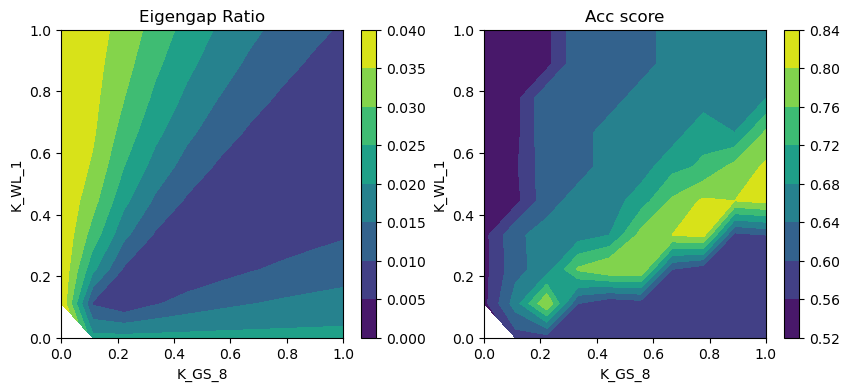

In [865]:
K_list = [K_GS_8, K_WL_1]
X, Y, Z, acc_score_list = getMeshGrid(K_list)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
cp = ax1.contourf(X, Y, Z)
f.colorbar(cp,ax=ax1) # Add a colorbar to a plot
ax1.set_xlabel('K_GS_8')
ax1.set_ylabel('K_WL_1')
ax1.set_title('Eigengap Ratio')
cp2 = ax2.contourf(X, Y, acc_score_list)
f.colorbar(cp2,ax=ax2)# Add a colorbar to a plot
ax2.set_xlabel('K_GS_8')
ax2.set_ylabel('K_WL_1')
ax2.set_title('Acc score')
plt.show()

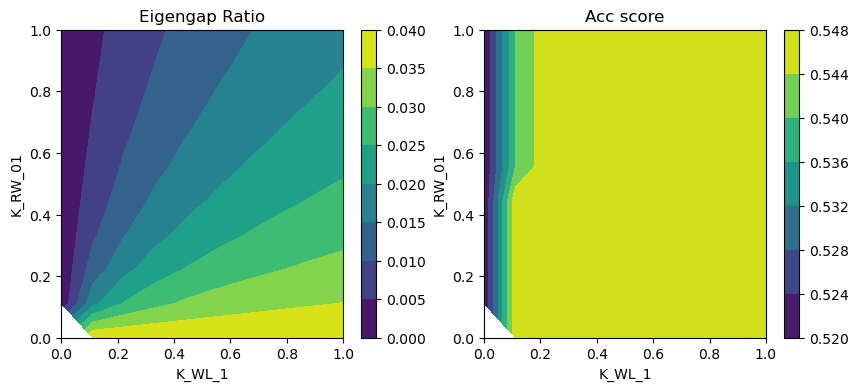

In [867]:
K_list = [K_WL_1, K_RW_01]
X, Y, Z, acc_score_list = getMeshGrid(K_list)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
cp = ax1.contourf(X, Y, Z)
f.colorbar(cp,ax=ax1) # Add a colorbar to a plot
ax1.set_xlabel('K_WL_1')
ax1.set_ylabel('K_RW_01')
ax1.set_title('Eigengap Ratio')
cp2 = ax2.contourf(X, Y, acc_score_list)
f.colorbar(cp2,ax=ax2)# Add a colorbar to a plot
ax2.set_xlabel('K_WL_1')
ax2.set_ylabel('K_RW_01')
ax2.set_title('Acc score')
plt.show()

[array([0.02037416]), array([0.03790362]), array([0.00101823])]
----- At No.1 iteration: weights [0.33340306 0.33334265 0.33325429] sum: 1.0 norm: 0.5774-----
grad: [ -946.30723036 -1006.72328573 -1095.08411267] eigengap ratio: [0.00642643]
acc_score: 0.6533333333333333
----- At No.11 iteration: weights [0.33410136 0.33343592 0.33246272] sum: 1.0 norm: 0.5774-----
grad: [ -948.69886963 -1009.27183501 -1097.85694126] eigengap ratio: [0.00641592]
acc_score: 0.6533333333333333
----- At No.21 iteration: weights [0.33480145 0.33352942 0.33166913] sum: 1.0 norm: 0.5774-----
grad: [ -951.10103692 -1011.8316199  -1100.64199642] eigengap ratio: [0.0064054]
acc_score: 0.6533333333333333
----- At No.31 iteration: weights [0.33550335 0.33362314 0.3308735 ] sum: 1.0 norm: 0.5774-----
grad: [ -953.51378982 -1014.40270202 -1103.43934521] eigengap ratio: [0.00639487]
acc_score: 0.6533333333333333
----- At No.41 iteration: weights [0.33620707 0.33371709 0.33007584] sum: 1.0 norm: 0.5774-----
grad: [ -9

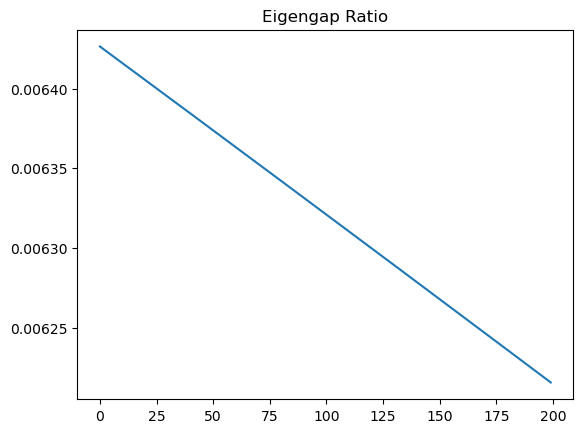

[array([0.02037416]), array([0.03790362]), array([0.00101823])]


In [734]:
K_list = [K_GS_8, K_WL_1, K_RW_01]
n = len(K_list)
class_num = 2

score_dict = {'Accuracy': []}
weights_list = list()
gap_list = list()

stepsize = 1e-6
num_iter = 200
num_iter_mom = 50

eigen_weights_list = []
for K_train in K_list:
    eigenValues, eigenV_kp1, eigenV = cal_Lap_eigen(K_train, class_num = 2)
    eigen_gap = np.diff(eigenValues)
    eigen_weights_list.append(eigen_gap)
print(eigen_weights_list)
eigen_weights = np.sum(np.array(eigen_weights_list)) - np.array(eigen_weights_list)
eigen_weights /= np.sum(eigen_weights)

weights = np.ones(n)/n #eigen_weights.ravel()# np.array([0.6, 0.2, 0.2]) # np.ones(n)/n
update_w = np.zeros(n)

it = 0
for i in range(num_iter):
    if i < num_iter_mom:
        momentum = 0#.9
    else:
        momentum = 0#.3

    K_new = np.nan_to_num(get_Knew(weights, K_list))
    grad, obj = cal_grad_w(weights, K_list, K_new, class_num)
    
    '''momentum update '''
    update_w = (momentum * update_w) + (stepsize * grad)
    weights += update_w
    weights = project_simplex(weights)

    weights_list.append(weights)
    gap_list.append(obj)
    it += 1

    if i%10 == 0: 
        weight_norm = np.linalg.norm(weights)
        weight_sum = np.sum(weights)
        print(f'----- At No.{i+1} iteration: weights {weights} sum: {np.round(weight_sum, 4)} norm: {np.round(weight_norm, 4)}-----')
        print("grad:", grad, 'eigengap ratio:', obj)

    y_pred = SpectralClustering(n_clusters = class_num, 
                                random_state = 0,
                                affinity = 'precomputed').fit_predict(K_new)

    acc_score = cal_acc(y_train_adj, y_pred)
    # nmi = metrics.normalized_mutual_info_score(y_train_adj, y_pred)
    if i%10 == 0: print("acc_score:", acc_score)
    score_dict['Accuracy'].append(acc_score)
    # score_dict['Normalized_Mutual_Info'].append(nmi)

plt.plot(range(num_iter), gap_list)
plt.title(f'Eigengap Ratio')
plt.xlabel = 'Num of Iterations'
plt.show()

print(eigen_weights_list)

[array([0.02037416]), array([0.03790362]), array([0.00101823])]
----- At No.1 iteration: weights [0.32843417 0.18041759 0.49114823] sum: 1.0 norm: 0.6178-----
grad: [-3186.61604843 -3390.00390573 -3687.03552955] eigengap ratio: [0.00228132]
acc_score: 0.7733333333333333
----- At No.11 iteration: weights [0.33077672 0.18072919 0.48849409] sum: 1.0 norm: 0.617-----
grad: [-3177.41526151 -3380.26219348 -3676.44640326] eigengap ratio: [0.00229323]
acc_score: 0.7666666666666667
----- At No.21 iteration: weights [0.33311245 0.18103971 0.48584784] sum: 1.0 norm: 0.6163-----
grad: [-3167.27913248 -3369.52512626 -3664.7746613 ] eigengap ratio: [0.00230585]
acc_score: 0.7666666666666667
----- At No.31 iteration: weights [0.3354407  0.18134907 0.48321023] sum: 1.0 norm: 0.6155-----
grad: [-3156.25816983 -3357.84638399 -3652.07868012] eigengap ratio: [0.00231916]
acc_score: 0.7666666666666667
----- At No.41 iteration: weights [0.33776083 0.18165718 0.48058199] sum: 1.0 norm: 0.6149-----
grad: [-31

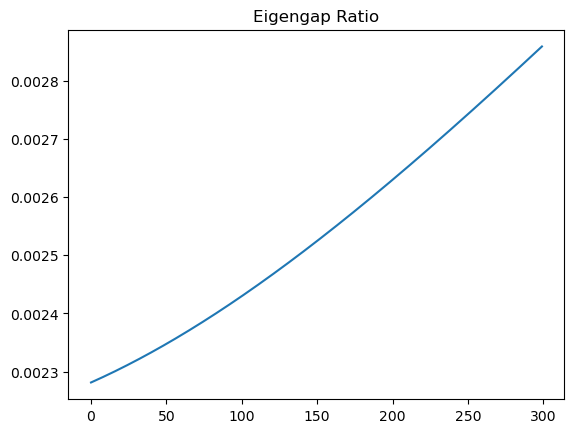

[array([0.02037416]), array([0.03790362]), array([0.00101823])]


In [725]:
K_list = [K_GS_8, K_WL_1, K_RW_01]
n = len(K_list)
class_num = 2

score_dict = {'Accuracy': []}
weights_list = list()
gap_list = list()

stepsize = 1e-6
num_iter = 300
num_iter_mom = 50

eigen_weights_list = []
for K_train in K_list:
    eigenValues, eigenV_kp1, eigenV = cal_Lap_eigen(K_train, class_num = 2)
    eigen_gap = np.diff(eigenValues)
    eigen_weights_list.append(eigen_gap)
print(eigen_weights_list)
eigen_weights = np.sum(np.array(eigen_weights_list)) - np.array(eigen_weights_list)
eigen_weights /= np.sum(eigen_weights)

weights =  eigen_weights.ravel() #np.ones(n)/n #eigen_weights.ravel()# np.array([0.6, 0.2, 0.2]) # np.ones(n)/n
update_w = np.zeros(n)

m = np.zeros(n)
v = np.zeros(n)
beta1 = 0.8 # factor for average gradient
beta2 = 0.999 # factor for average squared gradient

it = 0
for i in range(num_iter):
    if i < num_iter_mom:
        momentum = 0#.9
    else:
        momentum = 0#.3

    K_new = np.nan_to_num(get_Knew(weights, K_list))
    grad, obj = cal_grad_w(weights, K_list, K_new, class_num)
    
    '''momentum update '''
    update_w = (momentum * update_w) + (stepsize * grad)
    weights += update_w
    '''adam update '''
    # weights, m, v = update_adam(weights, grad, i, m, v, stepsize, beta1, beta2)
    weights = non_negative(weights)
    weights = project_simplex(weights)
    # weights = scale_zero2one(weights)
    # weights /= np.sum(weights)
    
    # weights = scale_zero2one(weights)

    weights_list.append(weights)
    gap_list.append(obj)
    it += 1

    if i%10 == 0: 
        weight_norm = np.linalg.norm(weights)
        weight_sum = np.sum(weights)
        print(f'----- At No.{i+1} iteration: weights {weights} sum: {np.round(weight_sum, 4)} norm: {np.round(weight_norm, 4)}-----')
        print("grad:", grad, 'eigengap ratio:', obj)

    y_pred = SpectralClustering(n_clusters = class_num, 
                                random_state = 0,
                                affinity = 'precomputed').fit_predict(K_new)

    acc_score = cal_acc(y_train_adj, y_pred)
    # nmi = metrics.normalized_mutual_info_score(y_train_adj, y_pred)
    if i%10 == 0: print("acc_score:", acc_score)
    score_dict['Accuracy'].append(acc_score)
    # score_dict['Normalized_Mutual_Info'].append(nmi)

plt.plot(range(num_iter), gap_list)
plt.title(f'Eigengap Ratio')
plt.xlabel = 'Num of Iterations'
plt.show()

print(eigen_weights_list)

[array([0.02037416]), array([0.03790362]), array([0.00101823])]
----- At No.1 iteration: weights [0.32843417 0.18041759 0.49114823] sum: 1.0 norm: 0.6178-----
grad: [-3186.61604843 -3390.00390573 -3687.03552955] eigengap ratio: [0.00228132]
acc_score: 0.7733333333333333
----- At No.11 iteration: weights [0.33077672 0.18072919 0.48849409] sum: 1.0 norm: 0.617-----
grad: [-3177.41526151 -3380.26219348 -3676.44640326] eigengap ratio: [0.00229323]
acc_score: 0.7666666666666667
----- At No.21 iteration: weights [0.33311245 0.18103971 0.48584784] sum: 1.0 norm: 0.6163-----
grad: [-3167.27913249 -3369.52512626 -3664.7746613 ] eigengap ratio: [0.00230585]
acc_score: 0.7666666666666667
----- At No.31 iteration: weights [0.3354407  0.18134907 0.48321023] sum: 1.0 norm: 0.6155-----
grad: [-3156.25816983 -3357.84638399 -3652.07868012] eigengap ratio: [0.00231916]
acc_score: 0.7666666666666667
----- At No.41 iteration: weights [0.33776083 0.18165718 0.48058199] sum: 1.0 norm: 0.6149-----
grad: [-31

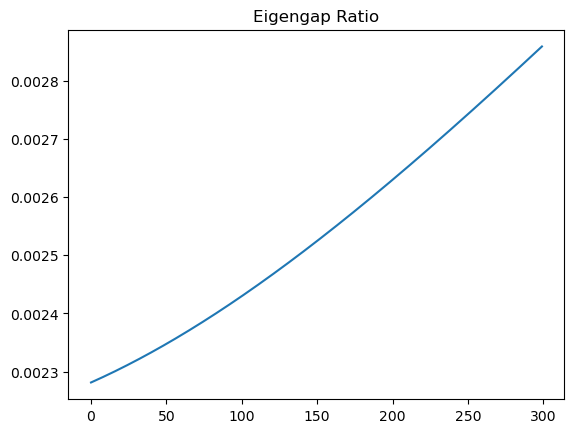

[array([0.02037416]), array([0.03790362]), array([0.00101823])]


In [724]:
K_list = [K_GS_8, K_WL_1, K_RW_01]
n = len(K_list)
class_num = 2

score_dict = {'Accuracy': []}
weights_list = list()
gap_list = list()

stepsize = 1e-6
num_iter = 300
num_iter_mom = 50

eigen_weights_list = []
for K_train in K_list:
    eigenValues, eigenV_kp1, eigenV = cal_Lap_eigen(K_train, class_num = 2)
    eigen_gap = np.diff(eigenValues)
    eigen_weights_list.append(eigen_gap)
print(eigen_weights_list)
eigen_weights = np.sum(np.array(eigen_weights_list)) - np.array(eigen_weights_list)
eigen_weights /= np.sum(eigen_weights)

weights =  eigen_weights.ravel() #np.ones(n)/n #eigen_weights.ravel()# np.array([0.6, 0.2, 0.2]) # np.ones(n)/n
update_w = np.zeros(n)

m = np.zeros(n)
v = np.zeros(n)
beta1 = 0.8 # factor for average gradient
beta2 = 0.999 # factor for average squared gradient

it = 0
for i in range(num_iter):
    if i < num_iter_mom:
        momentum = 0#.9
    else:
        momentum = 0#.3

    K_new = np.nan_to_num(get_Knew(weights, K_list))
    grad, obj = cal_grad_w(weights, K_list, K_new, class_num)
    
    '''momentum update '''
    update_w = (momentum * update_w) + (stepsize * grad)
    weights += update_w
    weights = project_simplex(weights)

    weights_list.append(weights)
    gap_list.append(obj)
    it += 1

    if i%10 == 0: 
        weight_norm = np.linalg.norm(weights)
        weight_sum = np.sum(weights)
        print(f'----- At No.{i+1} iteration: weights {weights} sum: {np.round(weight_sum, 4)} norm: {np.round(weight_norm, 4)}-----')
        print("grad:", grad, 'eigengap ratio:', obj)

    y_pred = SpectralClustering(n_clusters = class_num, 
                                random_state = 0,
                                affinity = 'precomputed').fit_predict(K_new)

    acc_score = cal_acc(y_train_adj, y_pred)
    # nmi = metrics.normalized_mutual_info_score(y_train_adj, y_pred)
    if i%10 == 0: print("acc_score:", acc_score)
    score_dict['Accuracy'].append(acc_score)
    # score_dict['Normalized_Mutual_Info'].append(nmi)

plt.plot(range(num_iter), gap_list)
plt.title(f'Eigengap Ratio')
plt.xlabel = 'Num of Iterations'
plt.show()

print(eigen_weights_list)

K's min eigenvalue: (-1.4281770317710115e-15-8.417420953914763e-17j)


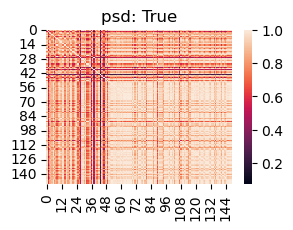

K's min eigenvalue: (-5.611890748382715e-15+0j)


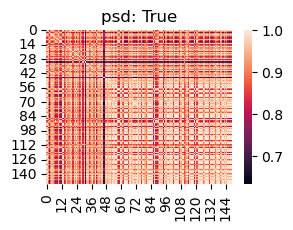

K's min eigenvalue: (-5.659048681740406e-15+0j)


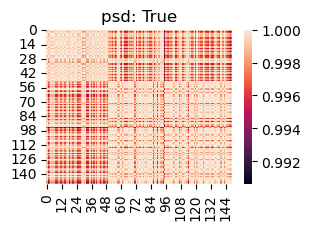

K's min eigenvalue: (-2.294041859283735e-15-1.5518259228101395e-16j)


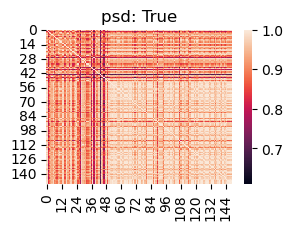

In [ ]:
for (K_train) in K_list:
    check_psd(K_train)
check_psd(K_new)

In [ ]:
print('===== Individual acc_score =====')
kernel_name = ['Graphlet Sampling (8)', 'Weisfeiler Lehman (1)', 'Random Walk (0.1)']
i = 0
class_num = 2
for K_candidate in K_list:
    y_pred = SpectralClustering(n_clusters = class_num, 
                                random_state = 0,
                                affinity = 'precomputed').fit_predict(K_candidate)

    acc_score = cal_acc(y_train_adj, y_pred)
    print(f"{kernel_name[i]}:", acc_score)
    i += 1

print('===== Joint kernel =====')
plt.plot(range(num_iter), pd.DataFrame(score_dict))
plt.title(f'{max(score_dict["Accuracy"])} (Joint kernel)')
plt.legend(list(score_dict.keys()))
plt.xlabel = 'Num of Iterations'
plt.show()

===== Individual acc_score =====
Graphlet Sampling (8): 0.58
Weisfeiler Lehman (1): 0.5466666666666666
Random Walk (0.1): 0.52
===== Joint kernel =====


[array([0.05566305]), array([0.07584212]), array([0.00492708])]
----- At No.1 iteration: weights [0.25 0.5  0.25] sum: 1.0 norm: 0.6124-----
grad: [ -66.74623783 -105.9723596  -125.19068912] eigen gap: [0.04840241]
acc_score: 0.6133333333333333
----- At No.11 iteration: weights [0.32282115 0.3172773  0.31377494] sum: 0.9539 norm: 0.5508-----
grad: [ -92.38441206 -146.69951002 -173.24961481] eigen gap: [0.03988232]
acc_score: 0.6133333333333333
----- At No.21 iteration: weights [0.32293799 0.31682739 0.31383908] sum: 0.9536 norm: 0.5506-----
grad: [ -92.46582    -146.82884018 -173.40224084] eigen gap: [0.0398645]
acc_score: 0.6133333333333333
----- At No.31 iteration: weights [0.322938   0.31682632 0.31383885] sum: 0.9536 norm: 0.5506-----
grad: [ -92.46603986 -146.82918944 -173.40265318] eigen gap: [0.03986447]
acc_score: 0.6133333333333333
----- At No.41 iteration: weights [0.322938   0.31682632 0.31383884] sum: 0.9536 norm: 0.5506-----
grad: [ -92.4660406  -146.82919063 -173.40265458

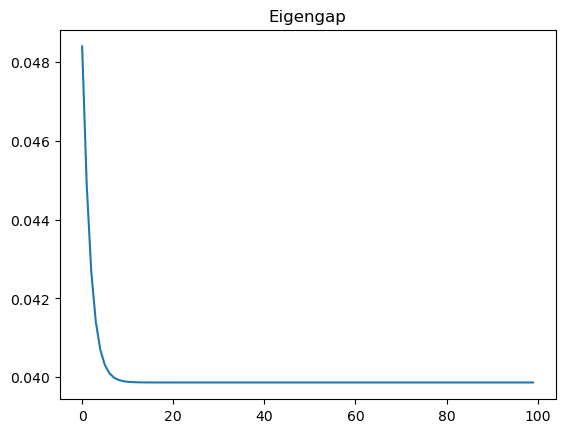

In [ ]:
K_list = [K_WL_10, K_SP, K_RW_05]
n = len(K_list)
class_num = 2

score_dict = {'Accuracy': []}
weights_list = list()
gap_list = list()

stepsize = 1e-4
num_iter = 100
num_iter_mom = 50

eigen_weights_list = []
for K_train in K_list:
    eigenValues, eigenV_kp1, eigenV = cal_Lap_eigen(K_train, class_num = 2)
    eigen_gap = np.diff(eigenValues)
    eigen_weights_list.append(eigen_gap)
print(eigen_weights_list)
# eigen_weights = np.sum(np.array(eigen_weights_list)) - np.array(eigen_weights_list)
# eigen_weights /= np.sum(eigen_weights)

weights = np.array([0.25, 0.5, 0.25]) # np.ones(n)/n  #eigen_weights.ravel() #eigen_weights.ravel() #np.ones(n)/n #np.ones(n)/n# np.array([0.6, 0.2, 0.2]) # np.ones(n)/n
update_w = np.zeros(n)

m = np.zeros(n)
v = np.zeros(n)
beta1 = 0.8 # factor for average gradient
beta2 = 0.999 # factor for average squared gradient

it = 0
for i in range(num_iter):
    if i < num_iter_mom:
        momentum = 0#.8
    else:
        momentum = 0#.2
   
    K_new = np.nan_to_num(get_Knew(weights, K_list))
    grad, obj = cal_grad_w(weights, K_list, K_new, class_num)
    
    if i%10 == 0: 
        weight_norm = np.linalg.norm(weights)
        weight_sum = np.sum(weights)
        print(f'----- At No.{i+1} iteration: weights {weights} sum: {np.round(weight_sum, 4)} norm: {np.round(weight_norm, 4)}-----')
        print("grad:", grad, 'eigengap ratio:', obj)
    
    '''momentum update '''
    update_w = (momentum * update_w) + (stepsize * grad)
    weights += update_w

    weights = project_simplex(weights)

    weights_list.append(weights)
    gap_list.append(obj)
    it += 1

    y_pred = SpectralClustering(n_clusters = class_num, 
                                random_state = 0,
                                affinity = 'precomputed').fit_predict(K_new)

    acc_score = cal_acc(y_train_adj, y_pred)
    # nmi = metrics.normalized_mutual_info_score(y_train_adj, y_pred)
    if i%10 == 0:
        print("acc_score:", acc_score)
    score_dict['Accuracy'].append(acc_score)
    # score_dict['Normalized_Mutual_Info'].append(nmi)

plt.plot(range(num_iter), gap_list)
plt.title(f'Eigengap')
plt.xlabel = 'Num of Iterations'
plt.show()

In [817]:
K_list = [K_WL_10, K_RW_05]
xlist = np.linspace(0.0, 1.0, 10)
ylist = np.linspace(0.0, 1.0, 10)
X, Y = np.meshgrid(xlist, ylist)
Z = []
acc_score_list = []
for (xx, yy) in list(zip(X, Y)):
    for (x, y) in list(zip(xx, yy)):
        # if (x + y == 0): 
        #     Z.append(0)
        #     acc_score_list.append(0)
            
        # else:
        weights = np.array([x,y])
        K_new = np.nan_to_num(get_Knew(weights, K_list))
        grad, obj = cal_grad_w(weights, K_list, K_new, class_num)
        Z.append(obj)

        y_pred = SpectralClustering(n_clusters = class_num, 
                                random_state = 0,
                                affinity = 'precomputed').fit_predict(K_new)
        acc_score = cal_acc(y_train_adj, y_pred)
        acc_score_list.append(acc_score)

Z = np.array(Z).reshape(len(xlist), len(ylist))
acc_score_list = np.array(acc_score_list).reshape(len(xlist), len(ylist))

Z[0][0] = None
acc_score_list[0][0] = None

plt.figure(1, (10, 4))
plt.subplot(1, 2, 1)
plt.contourf(X, Y, Z, 30)
plt.colorbar()
plt.title('Eigengap Ratio')
plt.subplot(1, 2, 2)
plt.contourf(X, Y, acc_score_list)
plt.colorbar()
plt.title('Acc score')
plt.show()

/var/folders/l9/jbc4cb656p15q1mbryhdxhym0000gn/T/ipykernel_52042/1943297094.py:62: RuntimeWarning: invalid value encountered in divide
  eigen_gap_ratio = eigen_gap/eigen_k
/var/folders/l9/jbc4cb656p15q1mbryhdxhym0000gn/T/ipykernel_52042/1943297094.py:65: RuntimeWarning: divide by zero encountered in power
  inv_trace1 = np.power(eigen_gap, -1) * (eigenV_kp1_trace - eigenV_trace)
/var/folders/l9/jbc4cb656p15q1mbryhdxhym0000gn/T/ipykernel_52042/1943297094.py:65: RuntimeWarning: invalid value encountered in multiply
  inv_trace1 = np.power(eigen_gap, -1) * (eigenV_kp1_trace - eigenV_trace)
/var/folders/l9/jbc4cb656p15q1mbryhdxhym0000gn/T/ipykernel_52042/1943297094.py:66: RuntimeWarning: divide by zero encountered in power
  inv_trace2 = np.power(eigen_k,-1) * (eigenV_trace)
/var/folders/l9/jbc4cb656p15q1mbryhdxhym0000gn/T/ipykernel_52042/1943297094.py:66: RuntimeWarning: invalid value encountered in scalar multiply
  inv_trace2 = np.power(eigen_k,-1) * (eigenV_trace)
/var/folders/l9/jbc4

In [741]:
K_list = [K_WL_10, K_SP, K_RW_05]
n = len(K_list)
class_num = 2

score_dict = {'Accuracy': []}
weights_list = list()
gap_list = list()

stepsize = 1e-5
num_iter = 300
num_iter_mom = 50

eigen_weights_list = []
for K_train in K_list:
    eigenValues, eigenV_kp1, eigenV = cal_Lap_eigen(K_train, class_num = 2)
    eigen_gap = np.diff(eigenValues)
    eigen_weights_list.append(eigen_gap)
print(eigen_weights_list)
eigen_weights = np.sum(np.array(eigen_weights_list)) - np.array(eigen_weights_list)
eigen_weights /= np.sum(eigen_weights)

weights = np.array([0.1, 0.8, 0.1]) #np.ones(n)/n #eigen_weights.ravel()# np.array([0.6, 0.2, 0.2]) # np.ones(n)/n
update_w = np.zeros(n)

m = np.zeros(n)
v = np.zeros(n)
beta1 = 0.8 # factor for average gradient
beta2 = 0.999 # factor for average squared gradient

it = 0
for i in range(num_iter):
    if i < num_iter_mom:
        momentum = 0#.9
    else:
        momentum = 0#.3

    K_new = np.nan_to_num(get_Knew(weights, K_list))
    grad, obj = cal_grad_w(weights, K_list, K_new, class_num)
    
    '''momentum update '''
    update_w = (momentum * update_w) + (stepsize * grad)
    weights += update_w
    weights = project_simplex(weights)

    weights_list.append(weights)
    gap_list.append(obj)
    it += 1

    if i%10 == 0: 
        weight_norm = np.linalg.norm(weights)
        weight_sum = np.sum(weights)
        print(f'----- At No.{i+1} iteration: weights {weights} sum: {np.round(weight_sum, 4)} norm: {np.round(weight_norm, 4)}-----')
        print("grad:", grad, 'eigengap ratio:', obj)

    y_pred = SpectralClustering(n_clusters = class_num, 
                                random_state = 0,
                                affinity = 'precomputed').fit_predict(K_new)

    acc_score = cal_acc(y_train_adj, y_pred)
    # nmi = metrics.normalized_mutual_info_score(y_train_adj, y_pred)
    if i%10 == 0: print("acc_score:", acc_score)
    score_dict['Accuracy'].append(acc_score)
    # score_dict['Normalized_Mutual_Info'].append(nmi)

plt.plot(range(num_iter), gap_list)
plt.title(f'Eigengap Ratio')
plt.xlabel = 'Num of Iterations'
plt.show()

print(eigen_weights_list)

[array([0.05566305]), array([0.07584212]), array([0.00492708])]
----- At No.1 iteration: weights [0.10022084 0.79995498 0.09982418] sum: 1.0 norm: 0.8124-----
grad: [-45.26388081 -71.84962556 -84.93025818] eigengap ratio: [0.07014464]
acc_score: 0.6466666666666666
----- At No.11 iteration: weights [0.10243014 0.79950464 0.09806522] sum: 1.0 norm: 0.812-----
grad: [-45.29586663 -71.90091028 -84.99156491] eigengap ratio: [0.07027884]
acc_score: 0.6466666666666666
----- At No.21 iteration: weights [0.10464105 0.79905399 0.09630496] sum: 1.0 norm: 0.8116-----
grad: [-45.32782675 -71.95215675 -85.05283002] eigengap ratio: [0.07041356]
acc_score: 0.6466666666666666
----- At No.31 iteration: weights [0.10685359 0.79860303 0.09454338] sum: 1.0 norm: 0.8112-----
grad: [-45.3597619  -72.00336611 -85.11405488] eigengap ratio: [0.0705488]
acc_score: 0.6466666666666666
----- At No.41 iteration: weights [0.10906774 0.79815177 0.09278049] sum: 1.0 norm: 0.8109-----
grad: [-45.39167278 -72.0545395  -8

[array([0.05566305]), array([0.07584212]), array([0.00492708])]


K's min eigenvalue: (-9.720003376568809e-17+0j)


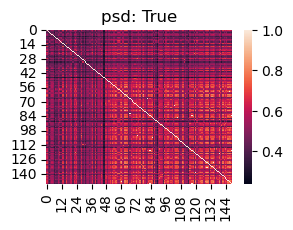

K's min eigenvalue: (-8.619957627057763e-16-6.07574468804349e-17j)


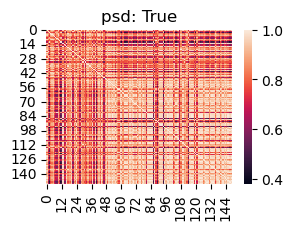

K's min eigenvalue: (-7.10995953838245e-15+0j)


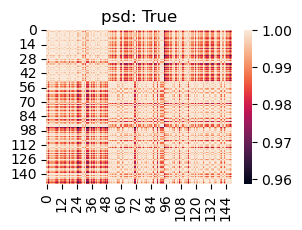

K's min eigenvalue: (-1.859277004913718e-16+0j)


In [742]:
for (K_train) in K_list:
    check_psd(K_train)
check_psd(K_new)

In [743]:
print('===== Individual acc_score =====')
kernel_name = ['Weisfeiler Lehman (10)', 'Shortest Path','Random Walk (0.5)']
i = 0
class_num = 2
for K_candidate in K_list:
    y_pred = SpectralClustering(n_clusters = class_num, 
                                random_state = 0,
                                affinity = 'precomputed').fit_predict(K_candidate)

    acc_score = cal_acc(y_train_adj, y_pred)
    print(f"{kernel_name[i]}:", acc_score)
    i += 1

print('===== Joint kernel =====')
plt.plot(range(num_iter), pd.DataFrame(score_dict))
plt.title(f'{score_dict["Accuracy"][-1]} (Joint kernel)')
plt.legend(list(score_dict.keys()))
plt.xlabel = 'Num of Iterations'
plt.show()

===== Individual acc_score =====
Weisfeiler Lehman (10): 0.5333333333333333
Shortest Path: 0.6533333333333333
Random Walk (0.5): 0.5066666666666667
===== Joint kernel =====


[array([0.05566305]), array([0.07584212]), array([0.00492708])]
----- At No.1 iteration: weights [0.25 0.5  0.25] sum: 1.0 norm: 0.6124-----
grad: [ -66.74623783 -105.9723596  -125.19068912] eigen gap: [0.04840241]
acc_score: 0.6133333333333333
----- At No.11 iteration: weights [0.25325689 0.49933284 0.24741027] sum: 1.0 norm: 0.6121-----
grad: [ -66.79839763 -106.05634152 -125.29122016] eigen gap: [0.04855272]
acc_score: 0.6133333333333333
----- At No.21 iteration: weights [0.25651645 0.49866518 0.24481837] sum: 1.0 norm: 0.6119-----
grad: [ -66.85026659 -106.13986929 -125.39122384] eigen gap: [0.04870382]
acc_score: 0.6133333333333333
----- At No.31 iteration: weights [0.25977866 0.49799701 0.24222433] sum: 1.0 norm: 0.6117-----
grad: [ -66.90184596 -106.22294493 -125.49070261] eigen gap: [0.04885571]
acc_score: 0.6133333333333333
----- At No.41 iteration: weights [0.26304351 0.49732834 0.23962815] sum: 1.0 norm: 0.6115-----
grad: [ -66.95313688 -106.30557029 -125.58965869] eigen gap

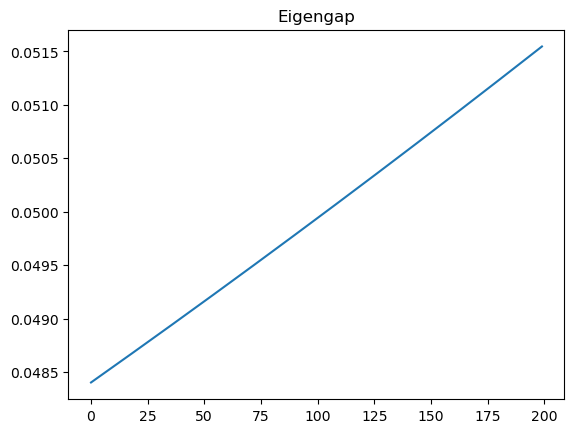

In [ ]:
K_list = [K_WL_10, K_SP, K_RW_05]
n = len(K_list)
class_num = 2

score_dict = {'Accuracy': []}
weights_list = list()
gap_list = list()

stepsize = 1e-5
num_iter = 200
num_iter_mom = 50

eigen_weights_list = []
for K_train in K_list:
    eigenValues, eigenV_kp1, eigenV = cal_Lap_eigen(K_train, class_num = 2)
    eigen_gap = np.diff(eigenValues)
    eigen_weights_list.append(eigen_gap)
print(eigen_weights_list)
# eigen_weights = np.sum(np.array(eigen_weights_list)) - np.array(eigen_weights_list)
# eigen_weights /= np.sum(eigen_weights)

weights = np.array([0.25, 0.5, 0.25])# np.ones(n)/n  #eigen_weights.ravel() #eigen_weights.ravel() #np.ones(n)/n #np.ones(n)/n# np.array([0.6, 0.2, 0.2]) # np.ones(n)/n
update_w = np.zeros(n)

m = np.zeros(n)
v = np.zeros(n)
beta1 = 0.8 # factor for average gradient
beta2 = 0.999 # factor for average squared gradient

it = 0
for i in range(num_iter):
    if i < num_iter_mom:
        momentum = 0#.8
    else:
        momentum = 0#.2
   
    K_new = np.nan_to_num(get_Knew(weights, K_list))
    grad, obj = cal_grad_w(weights, K_list, K_new, class_num)
    
    if i%10 == 0: 
        weight_norm = np.linalg.norm(weights)
        weight_sum = np.sum(weights)
        print(f'----- At No.{i+1} iteration: weights {weights} sum: {np.round(weight_sum, 4)} norm: {np.round(weight_norm, 4)}-----')
        print("grad:", grad, 'eigengap ratio:', obj)
    
    '''momentum update '''
    update_w = (momentum * update_w) + (stepsize * grad)
    weights += update_w
    '''adam update '''
    # weights, m, v = update_adam(weights, grad, i, m, v, stepsize, beta1, beta2)
    
    # weights /= np.sum(weights)
    weights = project_simplex(weights)
    # weights = non_negative(weights)

    weights_list.append(weights)
    gap_list.append(obj)
    it += 1

    y_pred = SpectralClustering(n_clusters = class_num, 
                                random_state = 0,
                                affinity = 'precomputed').fit_predict(K_new)

    acc_score = cal_acc(y_train_adj, y_pred)
    # nmi = metrics.normalized_mutual_info_score(y_train_adj, y_pred)
    if i%10 == 0:
        print("acc_score:", acc_score)
    score_dict['Accuracy'].append(acc_score)
    # score_dict['Normalized_Mutual_Info'].append(nmi)

plt.plot(range(num_iter), gap_list)
plt.title(f'Eigengap')
plt.xlabel = 'Num of Iterations'
plt.show()


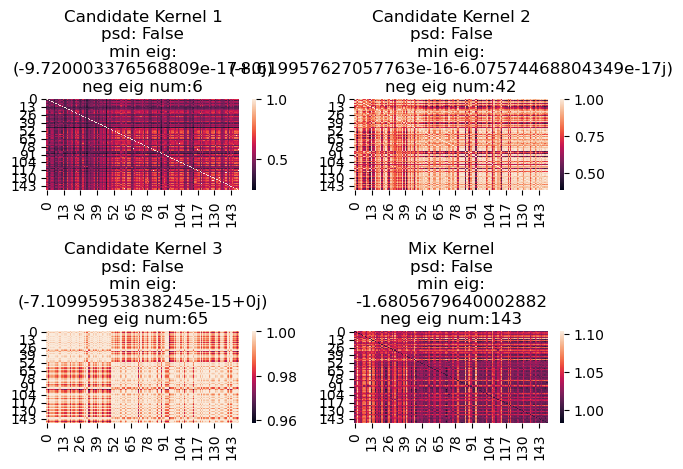

In [ ]:
idx = 0
fig, axes = plt.subplots(nrows=2, ncols=2)
for (K_train) in K_list:
    eigenValues = np.linalg.eigvals(K_train) #scipy.linalg.eigh(K_train, eigvals_only=True)
    if min(eigenValues) < 0: 
        psd = f'False\nmin eig:\n{min(eigenValues)}\nneg eig num:{len(np.argwhere(eigenValues<0))}'
    else:
        psd = 'True'

    plt.subplot(2, 2, idx+1)
    sns.heatmap(K_train)
    plt.title(f'Candidate Kernel {idx+1}\npsd: {psd}')
    idx += 1
    
# plt.figure(1, (3, 2))
plt.subplot(2, 2, idx+1)
sns.heatmap(K_new)
eigenValues = np.linalg.eigvals(K_new) #scipy.linalg.eigh(K_new, eigvals_only=True)
if min(eigenValues) < 0: 
    psd = f'False\nmin eig:\n{min(eigenValues)}\nneg eig num:{len(np.argwhere(eigenValues<0))}'
else:
    psd = 'True'
plt.title(f'Mix Kernel\npsd: {psd}')
fig.tight_layout()
plt.show()

===== Individual acc_score =====
Weisfeiler Lehman (10): 0.5333333333333333
Shortest Path: 0.6533333333333333
Random Walk (0.5): 0.5066666666666667
===== Joint kernel =====


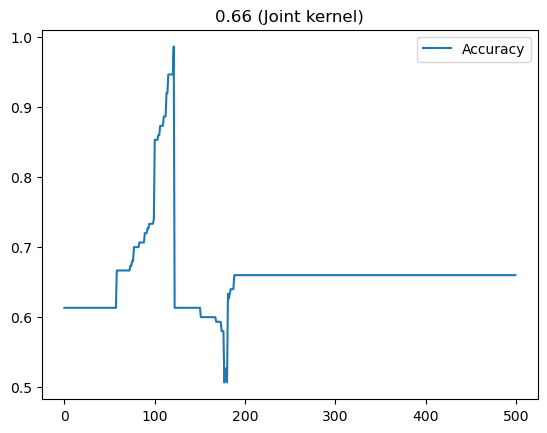

In [ ]:
print('===== Individual acc_score =====')
kernel_name = ['Weisfeiler Lehman (10)', 'Shortest Path','Random Walk (0.5)']
i = 0
class_num = 2
for K_candidate in K_list:
    y_pred = SpectralClustering(n_clusters = class_num, 
                                random_state = 0,
                                affinity = 'precomputed').fit_predict(K_candidate)

    acc_score = cal_acc(y_train_adj, y_pred)
    print(f"{kernel_name[i]}:", acc_score)
    i += 1

print('===== Joint kernel =====')
plt.plot(range(num_iter), pd.DataFrame(score_dict))
plt.title(f'{score_dict["Accuracy"][-1]} (Joint kernel)')
plt.legend(list(score_dict.keys()))
plt.xlabel = 'Num of Iterations'
plt.show()

In [ ]:
from sklearn.svm import OneClassSVM, SVC
from sklearn.metrics import roc_auc_score, accuracy_score

In [ ]:
def perform_SVC(K, K_test):
    # Uses the SVM classifier to perform classification
    clf = SVC(kernel="precomputed", tol=1e-6, probability = True)
    print('start fitting SVM...')
    clf.fit(K, y_train_adj)

    y_train_pred_proba = clf.predict_proba(K)
    y_train_pred = clf.classes_[np.argmax(y_train_pred_proba, axis = 1)]
    # print("Train:", y_train_pred)
    print("Train ACC: %.3f"%(accuracy_score(y_train_adj, y_train_pred)))

    y_test_pred_proba = clf.predict_proba(K_test)
    y_test_pred = clf.classes_[np.argmax(y_test_pred_proba, axis = 1)]
    
    # print("Test:",y_test_pred)
    print("Test ACC: %.3f"%(accuracy_score(y_test_adj, y_test_pred)))

In [ ]:
def cal_distance_ratio(K, y):
    n, m = K.shape
    l = len(y)
    assert((n == m) & (n == l))
    d_intra = 0
    d_inter = 0
    for i in range(n):
        for j in range(n):
            dij = K[i, i] + K[j, j] - 2*K[i, j]
            if (y[i] == y[j]):
                d_intra += dij
            else:
                d_inter += dij

    d_ratio = np.log(d_intra/d_inter)
    return d_ratio

In [ ]:
perform_SVC(K_RW_05, K_RW_05_test)
print("Distance ratio:",cal_distance_ratio(K_RW_05, y_train_adj))

In [ ]:
perform_SVC(K_RW_01, K_RW_01_test)
print("Distance ratio:",cal_distance_ratio(K_RW_01, y_train_adj))

In [ ]:
perform_SVC(K_SP, K_SP_test)
print("Distance ratio:",cal_distance_ratio(K_SP, y_train_adj))

In [ ]:
perform_SVC(K_GS_8, K_GS_8_test)
print("Distance ratio:",cal_distance_ratio(K_GS_8, y_train_adj))

In [ ]:
perform_SVC(K_GS_5, K_GS_5_test)
print("Distance ratio:",cal_distance_ratio(K_GS_5, y_train_adj))

In [ ]:
perform_SVC(K_WL_1, K_WL_1_test)
print("Distance ratio:",cal_distance_ratio(K_WL_1, y_train_adj))

In [ ]:
perform_SVC(K_WL_10, K_WL_10_test)
print("Distance ratio:",cal_distance_ratio(K_WL_10, y_train_adj))

## Kernel Selection in Support Vector Machines Using Gram-Matrix Properties
```text
@inproceedings{valerio2014kernel,
title={Kernel selection in support vector machines using gram-matrix properties},
author={Valerio, Roberto and Vilalta, Ricardo},
booktitle={Proceedings of the 27th international conference on advances in neural information processing systems. Workshop on modern nonparametrics: automating the learning pipeline, NIPS},
volume={14},
pages={2--4},
year={2014}
}
```
There is a new meta-feature as a relevant property of the Gram matrix, named Distance Ratio, which measures inter-class and intra-class distances in the feature space, and yields substantial improvements of learning by graph kernel.

1. Generate a distance matrix $D$ oer feature space.
    
    $D(x_i, x_j) = D_{ij} = K_{ii} + K_{jj} - 2K_{ij}$

    where $K_{ij} = K(x_i, x_j)$

2. Compute the intra-class distances directly in feature space.
 
    $D_{intra} = \sum_{i=1}^n\sum_{j=1}^n h(i,j)$

    $h(i,j) = D_{ij}, if y_i=y_j; 0, otherwise$
    
3. Compute the inter-class distances directly in feature space.
 
    $D_{inter} = \sum_{i=1}^n\sum_{j=1}^n g(i,j)$

    $g(i,j) = D_{ij}, if y_i \neq y_j; 0, otherwise$

4. Define Distance Ratio as the ratio of class cohesiveness and class separability. We search for a Gram matrix that minimizes *Distance Ratio* as a form of graph kernel selection.

    $Distance Ratio = \dfrac{D_{intra}}{D_{inter}}$


---
- For a graph kernel $K^t$, denote $\tilde{D}^t := D_{inter}$ and $\hat{D}^t := D_{intra}$
- Take log transformation, *log-Distance Ratio* as $ \log(\tilde{D}^t)  - log(\hat{D}^t) $ 

### Adaptive linear combination of graph kernels

#### Notations 

- $K^{1:T} \triangleq \sum_{t=1}^T w_t K^t$
- $D^{1:T}_{ij} \triangleq K^{1:T}_{ii} + K^{1:T}_{jj} - 2K^{1:T}_{ij} =  \sum_{t=1}^T w_t K^t_{ii} +  \sum_{t=1}^T w_t K^t_{jj} - 2  \sum_{t=1}^T w_t K^t_{ij}$
- $D^{1:T}_{ij} =  \sum_{t=1}^T w_t (K^t_{ii}+K^t_{jj}-2K^t_{ij}):= \sum_{t=1}^T w_t D^t$

#### Loss

- $\mathcal{L} \triangleq \log (\tilde{D}^{1:T})  - \log(\hat{D}^{1:T})$
- $\mathcal{L} = \log (\sum_{t=1}^T w_t \tilde{D}^t)  - \log(\sum_{t=1}^T w_t \hat{D}^t)$
- $\max_{\{w_t\}_{t=1}^T} \mathcal{L} $

#### Derivative

- $\dfrac{\partial \mathcal{L}}{\partial w_t} = \dfrac{\tilde{D}^t}{\sum_{t=1}^T w_t \tilde{D}^t} - \dfrac{\hat{D}^t}{\sum_{t=1}^T w_t \hat{D}^t}$

---
#### Notations (exp)

- $K^{1:T} \triangleq \sum_{t=1}^T \exp (w_t K^t)$
- $D^{1:T}_{ij} \triangleq  \sum_{t=1}^T\exp \left( w_t (K^t_{ii}+K^t_{jj}-2K^t_{ij}) \right):= \sum_{t=1}^T\exp ( w_t D^t)$


#### Loss  (exp)

- $\mathcal{L} \triangleq \log (\tilde{D}^{1:T}) - \log (\hat{D}^{1:T} ) $
- $\mathcal{L} = \log \left(\sum_{t=1}^T\exp ( w_t \tilde{D}^t) \right)  - \log\left(\sum_{t=1}^T\exp ( w_t \hat{D}^t) \right)$
- $\max_{\{w_t\}_{t=1}^T} \mathcal{L} $

#### Derivative  (exp)

- $\dfrac{\partial \mathcal{L}}{\partial w_t} = \dfrac{\exp (w_t \tilde{D}^t)\tilde{D}^t}{\sum_{t=1}^T\exp ( w_t \tilde{D}^t)} - \dfrac{ \exp (w_t  \hat{D}^t) \hat{D}^t}{\sum_{t=1}^T\exp ( w_t  \hat{D}^t)  }$

In [ ]:
def cal_distance_ratio(K, y):
    n, m = K.shape
    l = len(y)
    assert((n == m) & (n == l))
    d_intra = 0
    d_inter = 0
    for i in range(n):
        for j in range(n):
            dij = K[i, i] + K[j, j] - 2*K[i, j]
            if (y[i] == y[j]):
                d_intra += dij
            else:
                d_inter += dij

    d_ratio = np.log(d_intra/d_inter)
    return d_ratio

def cal_distance_ratio_exp(K, y):
    n, m = K.shape
    l = len(y)
    assert((n == m) & (n == l))
    d_intra = 0
    d_inter = 0
    for i in range(n):
        for j in range(n):
            dij = K[i, i] + K[j, j] - 2*K[i, j]
            if (y[i] == y[j]):
                d_intra += dij
            else:
                d_inter += dij

    d_ratio = d_intra - d_inter
    return d_ratio

In [ ]:
def cal_intra_inter_distances(K_list, y):
    m = len(K_list)
    n = K_list[0].shape[0]

    l = len(y)
    d_intra_list = [0,]*m
    d_inter_list = [0,]*m
    for i in range(n):
        for j in range(n):
            if (y[i] == y[j]):
                for t in range(m):
                    k = K_list[t]
                    dij = k[i, i] + k[j, j] - 2*k[i, j]
                    d_intra_list[t] += dij
            else:
                for t in range(m):
                    k = K_list[t]
                    dij = k[i, i] + k[j, j] - 2*k[i, j]
                    d_inter_list[t] += dij
                
    return np.array(d_intra_list, dtype=np.float128), np.array(d_inter_list, dtype=np.float128)

def cal_loss(D_intra, D_inter, w):
    return np.log(np.sum(w * D_intra)) - np.log(np.sum(w * D_inter))

def cal_loss_exp(D_intra, D_inter, w):
    return np.log(np.sum(np.exp(w * D_intra))) - np.log(np.sum(np.exp(w * D_inter)))

def cal_grad_wt(prev_w, D_intra, D_inter):
    grad_wt = D_intra/np.sum(prev_w * D_intra) - D_inter/np.sum(prev_w * D_inter) 
    return grad_wt

def cal_grad_wt_exp(prev_w, D_intra, D_inter):
    log_intra = (np.exp(prev_w * D_intra) * D_intra)/(np.sum(np.exp(prev_w * D_intra)))
    log_inter = (np.exp(prev_w * D_inter) * D_inter)/(np.sum(np.exp(prev_w * D_inter)))
    grad_wt = log_intra - log_inter
    return grad_wt

def train_w(D_intra, D_inter, y, lr, epochs, init_w, plot = True, type = 'exp'):
    
    prev_w = init_w.astype(np.float128)
    loss_list = []
    for epoch in tqdm(range(epochs)):

        if type == 'exp':
            grad = cal_grad_wt_exp(prev_w, D_intra, D_inter)
        else:
            grad = cal_grad_wt(prev_w, D_intra, D_inter)

        prev_w = prev_w - lr * grad
     
        # track loss
        if type == 'exp':
            loss_list.append(cal_loss_exp(D_intra, D_inter, prev_w))
        else:
            loss_list.append(cal_loss(D_intra, D_inter, prev_w))
    
    if plot:
        plt.figure(figsize = (2,2))
        plt.plot(loss_list)
        plt.title(type)
        plt.show()
        
    return prev_w

def get_Knew(K_list, prev_w):
    m = len(K_list)
    p, q = K_list[0].shape

    K_new = np.zeros((p, q))
    for t in range(m):
        K_new += prev_w[t] * K_list[t]
    return K_new

### Example:

Consider kernels:
- Weisfeiler Lehman (h = 1)
- Random walk (lambda = 0.1)
- Shortest Path

In [ ]:
K_train_list = [K_WL_1, K_RW_01, K_SP]
K_test_list = [K_WL_1_test, K_RW_01_test, K_SP_test]

n = len(K_train_list)
loss_type = 'exp'

D_intra, D_inter = cal_intra_inter_distances(K_train_list, y_train_adj)
print("Intra dist:",D_intra)
print("Inter dist:",D_inter)


# init_w = np.ones(n)/n
# Here, instead of uniform weights, we consider the scale of distances as initial weights.
init_w = np.array(1-D_intra/sum(D_intra))
init_w /= sum(init_w)
print('Initial w:', init_w)

w = train_w(D_intra, D_inter, y_train_adj, 1e-10, 1000, init_w, type = loss_type)
print(f"Optimal W: {[np.round(ww,4) for ww in w]}")

K_new = get_Knew(K_train_list, w)
intra_dist, inter_dist = cal_intra_inter_distances([K_new], y_train_adj)
print("Intra dist: %.4f, Inter dist: %.4f"%(float(intra_dist), float(inter_dist)))
K_new_test = get_Knew(K_test_list, w)

print('========= K_train_list and K_test_list ==========')
for (K_train, K_test) in list(zip(K_train_list, K_test_list)):
    perform_SVC(K_train, K_test)
    # print("DisRatio:",cal_distance_ratio(K_train, y_train_adj))
    print("DisRatio:",cal_distance_ratio_exp(K_train, y_train_adj))

print('========= K_new and K_new_test ==========')
perform_SVC(K_new, K_new_test)
# print("DisRatio:",cal_distance_ratio(K_normalized, y_train_adj))
print("DisRatio:",cal_distance_ratio_exp(K_normalized, y_train_adj))

In [ ]:
u, s, vh = np.linalg.svd(K_new, full_matrices=False)

print("K_new's min sigma:",min(s))
if min(s) > 0:
    print('PSD')
else:
    print('Not PSD')

In [ ]:
idx = 0
for (K_train, K_test) in list(zip(K_train_list, K_test_list)):
    plt.figure(1, (6, 2))
    plt.subplot(1, 2, 1)
    plt.title(f'weight: {np.round(w[idx], 4)}')
    sns.heatmap(K_train)
    plt.subplot(1, 2, 2)
    sns.heatmap(K_test)
    plt.title(f'weight: {np.round(w[idx], 4)}')
    plt.show()
    idx += 1

plt.figure(1, (10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(K_new)
plt.title(f'Mix Gram (train)')
plt.subplot(1, 2, 2)
sns.heatmap(K_new_test)
plt.title(f'Mix Gram (test)')
plt.show()